# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

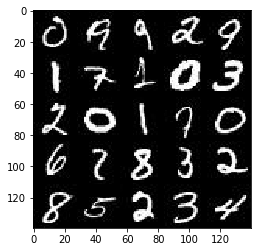

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

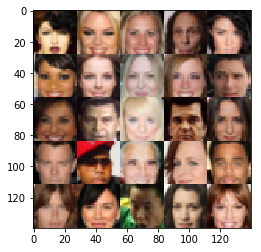

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [39]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):

        #input is 28x28x1 for MNIST, 28x28x3 for faces
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # 16x16x64 (?)
        
        x1 = tf.nn.dropout(x1, keep_prob=0.8)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x2 = tf.nn.dropout(x2, keep_prob=0.8)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [105]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x1 = tf.nn.dropout(x1, keep_prob=0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [106]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [107]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [108]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [109]:
import time
import datetime

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    
    show_every = 100
    print_every = 10
    
    sample_z = np.random.uniform(-1,1,size=(50,z_dim))
    steps = 0
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    g_training_opt, d_training_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    start_time = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            # Count number of batches
            number_of_batches = sum(1 for _ in get_batches(batch_size))
            
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                
                # Train Model
                steps += 1
                batch_images *= 2.0  # saw this on Slack as a tip to get better results, if I don't include it
                                     # the network doesn't get the background as black as it should be
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(g_training_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(d_training_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    

                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    progress = 100 * batch_i/(number_of_batches)
                   
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "{:>6.1f}% ".format(progress),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

                    end_time = time.time() # latest show_every batches
                    time_per_batch = show_every / (end_time - start_time)
                    remaining_batches = number_of_batches - batch_i + 1
                    seconds_remaining = remaining_batches / time_per_batch
                    
                    print("Estimated time remaining of epoch: {}".format(str(datetime.timedelta(seconds=seconds_remaining))))
                                                          
                    start_time = time.time()

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...    1.0%  Discriminator Loss: 0.8433... Generator Loss: 2.1517
Epoch 1/2...    2.0%  Discriminator Loss: 1.1257... Generator Loss: 2.5139
Epoch 1/2...    3.1%  Discriminator Loss: 0.3493... Generator Loss: 8.4112
Epoch 1/2...    4.2%  Discriminator Loss: 0.3533... Generator Loss: 6.3528
Epoch 1/2...    5.2%  Discriminator Loss: 0.3443... Generator Loss: 6.9255
Epoch 1/2...    6.3%  Discriminator Loss: 0.3972... Generator Loss: 6.7595
Epoch 1/2...    7.4%  Discriminator Loss: 0.3381... Generator Loss: 7.7888
Epoch 1/2...    8.4%  Discriminator Loss: 0.3558... Generator Loss: 8.4157
Epoch 1/2...    9.5%  Discriminator Loss: 0.3356... Generator Loss: 7.4639
Epoch 1/2...   10.6%  Discriminator Loss: 0.3357... Generator Loss: 7.7497


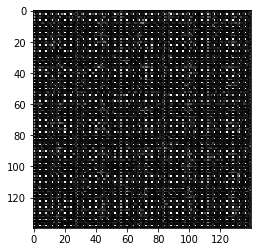

Estimated time remaining of epoch: 0:04:44.625815
Epoch 1/2...   11.6%  Discriminator Loss: 0.3372... Generator Loss: 7.2341
Epoch 1/2...   12.7%  Discriminator Loss: 0.3328... Generator Loss: 7.9480
Epoch 1/2...   13.8%  Discriminator Loss: 0.3328... Generator Loss: 8.2616
Epoch 1/2...   14.8%  Discriminator Loss: 0.3320... Generator Loss: 8.2087
Epoch 1/2...   15.9%  Discriminator Loss: 0.3374... Generator Loss: 7.9545
Epoch 1/2...   17.0%  Discriminator Loss: 0.3343... Generator Loss: 8.2627
Epoch 1/2...   18.0%  Discriminator Loss: 0.3362... Generator Loss: 8.3581
Epoch 1/2...   19.1%  Discriminator Loss: 0.3291... Generator Loss: 8.4547
Epoch 1/2...   20.2%  Discriminator Loss: 0.3403... Generator Loss: 8.7152
Epoch 1/2...   21.2%  Discriminator Loss: 0.3310... Generator Loss: 8.4249


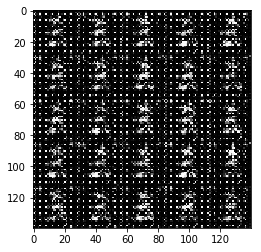

Estimated time remaining of epoch: 0:02:31.218681
Epoch 1/2...   22.3%  Discriminator Loss: 0.3330... Generator Loss: 8.4223
Epoch 1/2...   23.4%  Discriminator Loss: 0.3303... Generator Loss: 8.2651
Epoch 1/2...   24.4%  Discriminator Loss: 0.3294... Generator Loss: 8.3978
Epoch 1/2...   25.5%  Discriminator Loss: 0.3280... Generator Loss: 8.3893
Epoch 1/2...   26.6%  Discriminator Loss: 0.3296... Generator Loss: 8.6300
Epoch 1/2...   27.6%  Discriminator Loss: 0.3300... Generator Loss: 8.5574
Epoch 1/2...   28.7%  Discriminator Loss: 0.3291... Generator Loss: 8.7663
Epoch 1/2...   29.8%  Discriminator Loss: 0.3283... Generator Loss: 8.9252
Epoch 1/2...   30.8%  Discriminator Loss: 0.3286... Generator Loss: 8.7375
Epoch 1/2...   31.9%  Discriminator Loss: 0.3283... Generator Loss: 8.6976


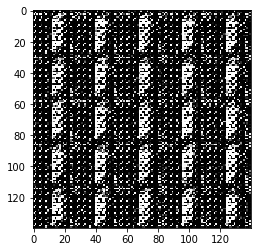

Estimated time remaining of epoch: 0:02:10.640116
Epoch 1/2...   33.0%  Discriminator Loss: 0.3284... Generator Loss: 8.8478
Epoch 1/2...   34.0%  Discriminator Loss: 0.3310... Generator Loss: 8.7979
Epoch 1/2...   35.1%  Discriminator Loss: 0.3270... Generator Loss: 9.2362
Epoch 1/2...   36.2%  Discriminator Loss: 0.3304... Generator Loss: 9.2569
Epoch 1/2...   37.2%  Discriminator Loss: 0.3284... Generator Loss: 9.4758
Epoch 1/2...   38.3%  Discriminator Loss: 0.3274... Generator Loss: 9.1395
Epoch 1/2...   39.4%  Discriminator Loss: 0.3273... Generator Loss: 9.4248
Epoch 1/2...   40.4%  Discriminator Loss: 0.3375... Generator Loss: 9.5897
Epoch 1/2...   41.5%  Discriminator Loss: 0.3304... Generator Loss: 9.4341
Epoch 1/2...   42.6%  Discriminator Loss: 0.3292... Generator Loss: 9.5417


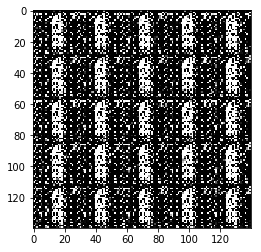

Estimated time remaining of epoch: 0:01:50.246626
Epoch 1/2...   43.6%  Discriminator Loss: 0.3365... Generator Loss: 8.7791
Epoch 1/2...   44.7%  Discriminator Loss: 0.8934... Generator Loss: 2.6472
Epoch 1/2...   45.8%  Discriminator Loss: 0.3833... Generator Loss: 4.9444
Epoch 1/2...   46.9%  Discriminator Loss: 0.4471... Generator Loss: 3.6791
Epoch 1/2...   47.9%  Discriminator Loss: 0.3683... Generator Loss: 4.7051
Epoch 1/2...   49.0%  Discriminator Loss: 0.3644... Generator Loss: 4.5601
Epoch 1/2...   50.1%  Discriminator Loss: 0.3792... Generator Loss: 3.5875
Epoch 1/2...   51.1%  Discriminator Loss: 1.0220... Generator Loss: 1.3553
Epoch 1/2...   52.2%  Discriminator Loss: 0.9873... Generator Loss: 1.6231
Epoch 1/2...   53.3%  Discriminator Loss: 0.6469... Generator Loss: 2.4333


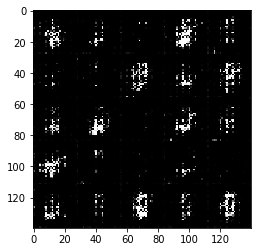

Estimated time remaining of epoch: 0:01:29.514065
Epoch 1/2...   54.3%  Discriminator Loss: 1.0116... Generator Loss: 5.4906
Epoch 1/2...   55.4%  Discriminator Loss: 0.4524... Generator Loss: 3.3662
Epoch 1/2...   56.5%  Discriminator Loss: 1.7219... Generator Loss: 0.4915
Epoch 1/2...   57.5%  Discriminator Loss: 0.6095... Generator Loss: 2.0212
Epoch 1/2...   58.6%  Discriminator Loss: 0.9320... Generator Loss: 1.6120
Epoch 1/2...   59.7%  Discriminator Loss: 1.0741... Generator Loss: 1.5081
Epoch 1/2...   60.7%  Discriminator Loss: 0.9461... Generator Loss: 1.2164
Epoch 1/2...   61.8%  Discriminator Loss: 0.8114... Generator Loss: 1.6945
Epoch 1/2...   62.9%  Discriminator Loss: 0.8979... Generator Loss: 1.2315
Epoch 1/2...   63.9%  Discriminator Loss: 0.8475... Generator Loss: 3.1999


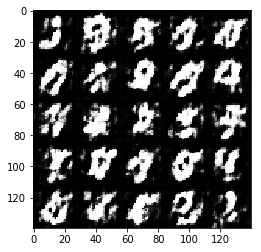

Estimated time remaining of epoch: 0:01:09.233806
Epoch 1/2...   65.0%  Discriminator Loss: 0.9586... Generator Loss: 1.0485
Epoch 1/2...   66.1%  Discriminator Loss: 0.9277... Generator Loss: 2.1661
Epoch 1/2...   67.1%  Discriminator Loss: 0.7649... Generator Loss: 1.5569
Epoch 1/2...   68.2%  Discriminator Loss: 0.9893... Generator Loss: 1.0146
Epoch 1/2...   69.3%  Discriminator Loss: 0.8964... Generator Loss: 1.0472
Epoch 1/2...   70.3%  Discriminator Loss: 0.9558... Generator Loss: 2.6780
Epoch 1/2...   71.4%  Discriminator Loss: 0.6584... Generator Loss: 2.4198
Epoch 1/2...   72.5%  Discriminator Loss: 0.7545... Generator Loss: 1.7550
Epoch 1/2...   73.5%  Discriminator Loss: 0.9458... Generator Loss: 1.0486
Epoch 1/2...   74.6%  Discriminator Loss: 0.6198... Generator Loss: 2.9011


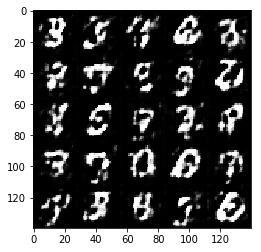

Estimated time remaining of epoch: 0:00:48.802229
Epoch 1/2...   75.7%  Discriminator Loss: 0.7980... Generator Loss: 1.7655
Epoch 1/2...   76.7%  Discriminator Loss: 0.6699... Generator Loss: 2.0359
Epoch 1/2...   77.8%  Discriminator Loss: 0.7894... Generator Loss: 2.9518
Epoch 1/2...   78.9%  Discriminator Loss: 0.7078... Generator Loss: 1.9629
Epoch 1/2...   79.9%  Discriminator Loss: 0.6296... Generator Loss: 2.2805
Epoch 1/2...   81.0%  Discriminator Loss: 1.0673... Generator Loss: 1.2407
Epoch 1/2...   82.1%  Discriminator Loss: 0.6638... Generator Loss: 1.8906
Epoch 1/2...   83.1%  Discriminator Loss: 0.6648... Generator Loss: 2.1293
Epoch 1/2...   84.2%  Discriminator Loss: 0.7750... Generator Loss: 1.6653
Epoch 1/2...   85.3%  Discriminator Loss: 0.7061... Generator Loss: 2.7925


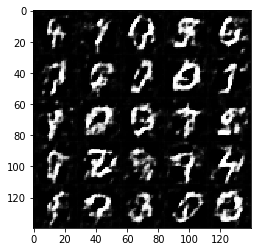

Estimated time remaining of epoch: 0:00:28.401792
Epoch 1/2...   86.3%  Discriminator Loss: 0.6489... Generator Loss: 2.0753
Epoch 1/2...   87.4%  Discriminator Loss: 0.8691... Generator Loss: 1.2625
Epoch 1/2...   88.5%  Discriminator Loss: 0.6970... Generator Loss: 1.6960
Epoch 1/2...   89.5%  Discriminator Loss: 1.3730... Generator Loss: 0.7589
Epoch 1/2...   90.6%  Discriminator Loss: 0.7790... Generator Loss: 1.9822
Epoch 1/2...   91.7%  Discriminator Loss: 0.6788... Generator Loss: 2.5010
Epoch 1/2...   92.7%  Discriminator Loss: 0.7252... Generator Loss: 1.9154
Epoch 1/2...   93.8%  Discriminator Loss: 0.7978... Generator Loss: 1.4071
Epoch 1/2...   94.9%  Discriminator Loss: 2.0220... Generator Loss: 4.7087
Epoch 1/2...   95.9%  Discriminator Loss: 0.9905... Generator Loss: 1.0760


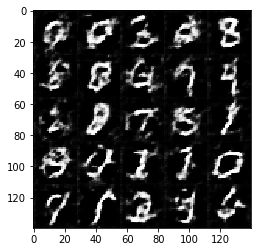

Estimated time remaining of epoch: 0:00:07.969023
Epoch 1/2...   97.0%  Discriminator Loss: 0.7706... Generator Loss: 1.9870
Epoch 1/2...   98.1%  Discriminator Loss: 0.6707... Generator Loss: 2.1903
Epoch 1/2...   99.1%  Discriminator Loss: 0.8292... Generator Loss: 2.5601
Epoch 2/2...    0.2%  Discriminator Loss: 0.6801... Generator Loss: 1.6604
Epoch 2/2...    1.3%  Discriminator Loss: 0.7666... Generator Loss: 1.7090
Epoch 2/2...    2.3%  Discriminator Loss: 0.6527... Generator Loss: 2.1320
Epoch 2/2...    3.4%  Discriminator Loss: 0.6640... Generator Loss: 1.9852
Epoch 2/2...    4.5%  Discriminator Loss: 0.6659... Generator Loss: 2.1817
Epoch 2/2...    5.5%  Discriminator Loss: 0.7233... Generator Loss: 2.4552
Epoch 2/2...    6.6%  Discriminator Loss: 0.6880... Generator Loss: 2.0344


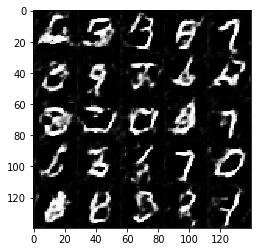

Estimated time remaining of epoch: 0:04:50.237583
Epoch 2/2...    7.7%  Discriminator Loss: 0.5961... Generator Loss: 1.9360
Epoch 2/2...    8.8%  Discriminator Loss: 0.7455... Generator Loss: 1.7112
Epoch 2/2...    9.8%  Discriminator Loss: 0.8902... Generator Loss: 1.3638
Epoch 2/2...   10.9%  Discriminator Loss: 0.7787... Generator Loss: 3.2817
Epoch 2/2...   12.0%  Discriminator Loss: 0.7338... Generator Loss: 1.6478
Epoch 2/2...   13.0%  Discriminator Loss: 0.9395... Generator Loss: 1.2184
Epoch 2/2...   14.1%  Discriminator Loss: 0.7756... Generator Loss: 2.4315
Epoch 2/2...   15.2%  Discriminator Loss: 0.8110... Generator Loss: 1.3144
Epoch 2/2...   16.2%  Discriminator Loss: 0.5738... Generator Loss: 1.9655
Epoch 2/2...   17.3%  Discriminator Loss: 0.6148... Generator Loss: 3.0527


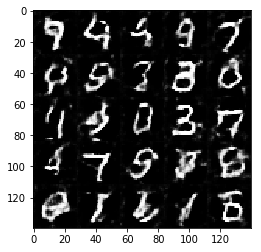

Estimated time remaining of epoch: 0:02:39.783419
Epoch 2/2...   18.4%  Discriminator Loss: 0.7582... Generator Loss: 1.7257
Epoch 2/2...   19.4%  Discriminator Loss: 0.7763... Generator Loss: 1.5042
Epoch 2/2...   20.5%  Discriminator Loss: 0.7160... Generator Loss: 2.7569
Epoch 2/2...   21.6%  Discriminator Loss: 0.6951... Generator Loss: 1.6075
Epoch 2/2...   22.6%  Discriminator Loss: 0.6887... Generator Loss: 1.9743
Epoch 2/2...   23.7%  Discriminator Loss: 0.6299... Generator Loss: 2.0019
Epoch 2/2...   24.8%  Discriminator Loss: 0.8945... Generator Loss: 2.9829
Epoch 2/2...   25.8%  Discriminator Loss: 0.6630... Generator Loss: 2.1099
Epoch 2/2...   26.9%  Discriminator Loss: 0.9903... Generator Loss: 0.9970
Epoch 2/2...   28.0%  Discriminator Loss: 0.6665... Generator Loss: 1.6131


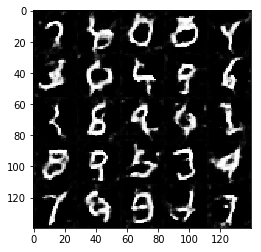

Estimated time remaining of epoch: 0:02:18.434118
Epoch 2/2...   29.0%  Discriminator Loss: 0.6700... Generator Loss: 1.4099
Epoch 2/2...   30.1%  Discriminator Loss: 0.6470... Generator Loss: 1.9917
Epoch 2/2...   31.2%  Discriminator Loss: 0.7564... Generator Loss: 1.4215
Epoch 2/2...   32.2%  Discriminator Loss: 0.6257... Generator Loss: 1.9553
Epoch 2/2...   33.3%  Discriminator Loss: 0.6133... Generator Loss: 1.9610
Epoch 2/2...   34.4%  Discriminator Loss: 0.7430... Generator Loss: 3.4217
Epoch 2/2...   35.4%  Discriminator Loss: 1.6673... Generator Loss: 4.5090
Epoch 2/2...   36.5%  Discriminator Loss: 0.6273... Generator Loss: 2.7959
Epoch 2/2...   37.6%  Discriminator Loss: 0.5901... Generator Loss: 2.3128
Epoch 2/2...   38.6%  Discriminator Loss: 0.5967... Generator Loss: 2.5511


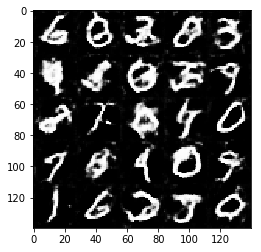

Estimated time remaining of epoch: 0:01:57.638826
Epoch 2/2...   39.7%  Discriminator Loss: 0.5797... Generator Loss: 2.2112
Epoch 2/2...   40.8%  Discriminator Loss: 0.6661... Generator Loss: 1.7725
Epoch 2/2...   41.8%  Discriminator Loss: 0.5761... Generator Loss: 2.6959
Epoch 2/2...   42.9%  Discriminator Loss: 0.7989... Generator Loss: 1.3060
Epoch 2/2...   44.0%  Discriminator Loss: 0.7060... Generator Loss: 1.3617
Epoch 2/2...   45.0%  Discriminator Loss: 0.6340... Generator Loss: 2.4031
Epoch 2/2...   46.1%  Discriminator Loss: 0.7141... Generator Loss: 1.5209
Epoch 2/2...   47.2%  Discriminator Loss: 0.5931... Generator Loss: 2.3046
Epoch 2/2...   48.2%  Discriminator Loss: 0.5919... Generator Loss: 2.2017
Epoch 2/2...   49.3%  Discriminator Loss: 0.6465... Generator Loss: 2.9993


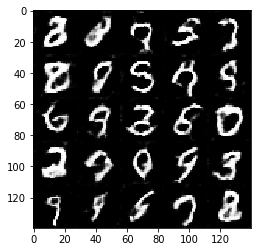

Estimated time remaining of epoch: 0:01:37.445216
Epoch 2/2...   50.4%  Discriminator Loss: 0.6059... Generator Loss: 2.2152
Epoch 2/2...   51.4%  Discriminator Loss: 0.6853... Generator Loss: 2.7993
Epoch 2/2...   52.5%  Discriminator Loss: 0.6558... Generator Loss: 2.0378
Epoch 2/2...   53.6%  Discriminator Loss: 0.7726... Generator Loss: 2.6568
Epoch 2/2...   54.6%  Discriminator Loss: 0.5529... Generator Loss: 1.9505
Epoch 2/2...   55.7%  Discriminator Loss: 0.5017... Generator Loss: 2.7919
Epoch 2/2...   56.8%  Discriminator Loss: 0.5776... Generator Loss: 2.5794
Epoch 2/2...   57.8%  Discriminator Loss: 0.5833... Generator Loss: 3.0106
Epoch 2/2...   58.9%  Discriminator Loss: 0.9855... Generator Loss: 3.4537
Epoch 2/2...   60.0%  Discriminator Loss: 0.9842... Generator Loss: 1.5484


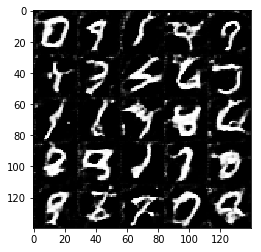

Estimated time remaining of epoch: 0:01:16.799313
Epoch 2/2...   61.0%  Discriminator Loss: 0.8610... Generator Loss: 1.4120
Epoch 2/2...   62.1%  Discriminator Loss: 0.6223... Generator Loss: 2.1713
Epoch 2/2...   63.2%  Discriminator Loss: 0.5724... Generator Loss: 2.3756
Epoch 2/2...   64.2%  Discriminator Loss: 0.6171... Generator Loss: 2.1848
Epoch 2/2...   65.3%  Discriminator Loss: 0.6849... Generator Loss: 2.4074
Epoch 2/2...   66.4%  Discriminator Loss: 0.7340... Generator Loss: 1.1205
Epoch 2/2...   67.4%  Discriminator Loss: 0.7010... Generator Loss: 3.1243
Epoch 2/2...   68.5%  Discriminator Loss: 0.5766... Generator Loss: 2.6842
Epoch 2/2...   69.6%  Discriminator Loss: 0.5691... Generator Loss: 1.9750
Epoch 2/2...   70.7%  Discriminator Loss: 0.6698... Generator Loss: 3.1362


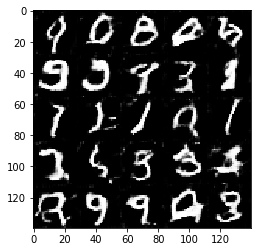

Estimated time remaining of epoch: 0:00:56.375344
Epoch 2/2...   71.7%  Discriminator Loss: 0.6353... Generator Loss: 2.5070
Epoch 2/2...   72.8%  Discriminator Loss: 0.7475... Generator Loss: 1.9241
Epoch 2/2...   73.9%  Discriminator Loss: 0.4935... Generator Loss: 2.3640
Epoch 2/2...   74.9%  Discriminator Loss: 0.6044... Generator Loss: 2.4576
Epoch 2/2...   76.0%  Discriminator Loss: 0.5454... Generator Loss: 1.7312
Epoch 2/2...   77.1%  Discriminator Loss: 0.7458... Generator Loss: 2.9331
Epoch 2/2...   78.1%  Discriminator Loss: 0.6047... Generator Loss: 2.9498
Epoch 2/2...   79.2%  Discriminator Loss: 0.6726... Generator Loss: 3.0773
Epoch 2/2...   80.3%  Discriminator Loss: 0.5577... Generator Loss: 2.5071
Epoch 2/2...   81.3%  Discriminator Loss: 0.8560... Generator Loss: 1.7184


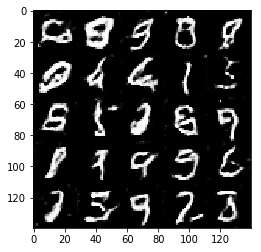

Estimated time remaining of epoch: 0:00:35.969928
Epoch 2/2...   82.4%  Discriminator Loss: 0.5410... Generator Loss: 2.2439
Epoch 2/2...   83.5%  Discriminator Loss: 0.5084... Generator Loss: 2.7474
Epoch 2/2...   84.5%  Discriminator Loss: 0.6953... Generator Loss: 1.4990
Epoch 2/2...   85.6%  Discriminator Loss: 0.9480... Generator Loss: 3.4421
Epoch 2/2...   86.7%  Discriminator Loss: 0.5274... Generator Loss: 2.3988
Epoch 2/2...   87.7%  Discriminator Loss: 1.0676... Generator Loss: 3.7508
Epoch 2/2...   88.8%  Discriminator Loss: 0.6383... Generator Loss: 1.6077
Epoch 2/2...   89.9%  Discriminator Loss: 0.6013... Generator Loss: 1.5848
Epoch 2/2...   90.9%  Discriminator Loss: 0.6448... Generator Loss: 1.6163
Epoch 2/2...   92.0%  Discriminator Loss: 0.8969... Generator Loss: 1.4494


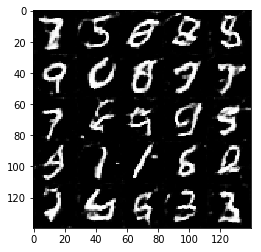

Estimated time remaining of epoch: 0:00:15.550888
Epoch 2/2...   93.1%  Discriminator Loss: 0.7474... Generator Loss: 1.1051
Epoch 2/2...   94.1%  Discriminator Loss: 0.5937... Generator Loss: 2.3926
Epoch 2/2...   95.2%  Discriminator Loss: 0.5454... Generator Loss: 3.3458
Epoch 2/2...   96.3%  Discriminator Loss: 0.6109... Generator Loss: 2.2629
Epoch 2/2...   97.3%  Discriminator Loss: 0.7918... Generator Loss: 1.5133
Epoch 2/2...   98.4%  Discriminator Loss: 0.5737... Generator Loss: 2.2840
Epoch 2/2...   99.5%  Discriminator Loss: 0.5494... Generator Loss: 1.7272


In [110]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...    0.1%  Discriminator Loss: 0.4458... Generator Loss: 3.0197
Epoch 1/1...    0.3%  Discriminator Loss: 0.4453... Generator Loss: 3.3007
Epoch 1/1...    0.5%  Discriminator Loss: 0.4113... Generator Loss: 3.2914
Epoch 1/1...    0.6%  Discriminator Loss: 0.3963... Generator Loss: 3.9701
Epoch 1/1...    0.8%  Discriminator Loss: 0.3892... Generator Loss: 3.6524
Epoch 1/1...    0.9%  Discriminator Loss: 0.5232... Generator Loss: 3.2337
Epoch 1/1...    1.1%  Discriminator Loss: 0.4619... Generator Loss: 3.5103
Epoch 1/1...    1.2%  Discriminator Loss: 0.3867... Generator Loss: 4.4866
Epoch 1/1...    1.4%  Discriminator Loss: 0.6344... Generator Loss: 2.3758
Epoch 1/1...    1.6%  Discriminator Loss: 0.3700... Generator Loss: 5.6481


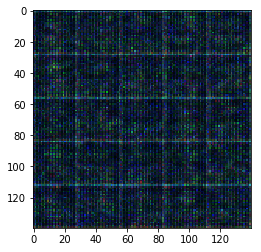

Estimated time remaining of epoch: 6:39:11.146688
Epoch 1/1...    1.7%  Discriminator Loss: 0.3818... Generator Loss: 5.2562
Epoch 1/1...    1.9%  Discriminator Loss: 0.3590... Generator Loss: 4.9424
Epoch 1/1...    2.0%  Discriminator Loss: 0.4632... Generator Loss: 2.8885
Epoch 1/1...    2.2%  Discriminator Loss: 0.4087... Generator Loss: 4.3670
Epoch 1/1...    2.4%  Discriminator Loss: 0.3935... Generator Loss: 4.1040
Epoch 1/1...    2.5%  Discriminator Loss: 0.4503... Generator Loss: 2.8657
Epoch 1/1...    2.7%  Discriminator Loss: 0.4930... Generator Loss: 2.6590
Epoch 1/1...    2.8%  Discriminator Loss: 0.4185... Generator Loss: 4.9023
Epoch 1/1...    3.0%  Discriminator Loss: 0.4856... Generator Loss: 2.8273
Epoch 1/1...    3.1%  Discriminator Loss: 0.4811... Generator Loss: 4.9607


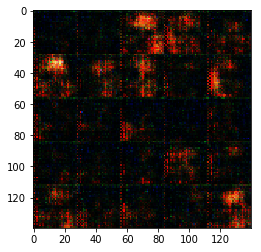

Estimated time remaining of epoch: 0:15:42.508753
Epoch 1/1...    3.3%  Discriminator Loss: 0.6192... Generator Loss: 2.2382
Epoch 1/1...    3.5%  Discriminator Loss: 0.4858... Generator Loss: 6.4890
Epoch 1/1...    3.6%  Discriminator Loss: 0.4029... Generator Loss: 2.9919
Epoch 1/1...    3.8%  Discriminator Loss: 0.5090... Generator Loss: 2.9976
Epoch 1/1...    3.9%  Discriminator Loss: 0.4377... Generator Loss: 4.4718
Epoch 1/1...    4.1%  Discriminator Loss: 1.0609... Generator Loss: 1.1853
Epoch 1/1...    4.2%  Discriminator Loss: 0.4385... Generator Loss: 4.1496
Epoch 1/1...    4.4%  Discriminator Loss: 0.3963... Generator Loss: 4.4889
Epoch 1/1...    4.6%  Discriminator Loss: 0.4118... Generator Loss: 5.5598
Epoch 1/1...    4.7%  Discriminator Loss: 0.7595... Generator Loss: 1.7964


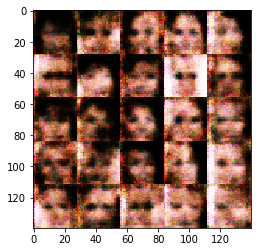

Estimated time remaining of epoch: 0:15:29.235567
Epoch 1/1...    4.9%  Discriminator Loss: 0.9547... Generator Loss: 1.1493
Epoch 1/1...    5.0%  Discriminator Loss: 0.5099... Generator Loss: 2.8399
Epoch 1/1...    5.2%  Discriminator Loss: 1.1306... Generator Loss: 0.8949
Epoch 1/1...    5.4%  Discriminator Loss: 0.4269... Generator Loss: 3.2713
Epoch 1/1...    5.5%  Discriminator Loss: 0.5090... Generator Loss: 3.1571
Epoch 1/1...    5.7%  Discriminator Loss: 0.4521... Generator Loss: 3.9042
Epoch 1/1...    5.8%  Discriminator Loss: 0.5674... Generator Loss: 2.4511
Epoch 1/1...    6.0%  Discriminator Loss: 1.0477... Generator Loss: 0.9467
Epoch 1/1...    6.1%  Discriminator Loss: 0.4727... Generator Loss: 3.3132
Epoch 1/1...    6.3%  Discriminator Loss: 0.4348... Generator Loss: 4.1068


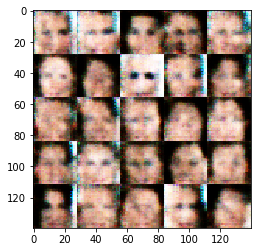

Estimated time remaining of epoch: 0:15:14.816352
Epoch 1/1...    6.5%  Discriminator Loss: 0.3994... Generator Loss: 2.9766
Epoch 1/1...    6.6%  Discriminator Loss: 1.1989... Generator Loss: 5.6631
Epoch 1/1...    6.8%  Discriminator Loss: 0.5682... Generator Loss: 1.8692
Epoch 1/1...    6.9%  Discriminator Loss: 0.5155... Generator Loss: 3.4660
Epoch 1/1...    7.1%  Discriminator Loss: 0.6123... Generator Loss: 2.0296
Epoch 1/1...    7.3%  Discriminator Loss: 0.5248... Generator Loss: 3.0353
Epoch 1/1...    7.4%  Discriminator Loss: 0.5158... Generator Loss: 2.4092
Epoch 1/1...    7.6%  Discriminator Loss: 0.7438... Generator Loss: 1.3593
Epoch 1/1...    7.7%  Discriminator Loss: 0.4784... Generator Loss: 2.6221
Epoch 1/1...    7.9%  Discriminator Loss: 0.5554... Generator Loss: 3.0819


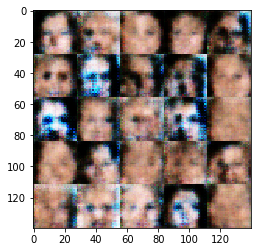

Estimated time remaining of epoch: 0:14:59.611928
Epoch 1/1...    8.0%  Discriminator Loss: 0.4460... Generator Loss: 2.9763
Epoch 1/1...    8.2%  Discriminator Loss: 0.5011... Generator Loss: 2.6100
Epoch 1/1...    8.4%  Discriminator Loss: 0.6478... Generator Loss: 2.0643
Epoch 1/1...    8.5%  Discriminator Loss: 0.7204... Generator Loss: 1.8539
Epoch 1/1...    8.7%  Discriminator Loss: 0.6913... Generator Loss: 2.4248
Epoch 1/1...    8.8%  Discriminator Loss: 0.6093... Generator Loss: 2.8895
Epoch 1/1...    9.0%  Discriminator Loss: 0.5168... Generator Loss: 2.7722
Epoch 1/1...    9.1%  Discriminator Loss: 0.5420... Generator Loss: 2.3211
Epoch 1/1...    9.3%  Discriminator Loss: 0.6024... Generator Loss: 2.1421
Epoch 1/1...    9.5%  Discriminator Loss: 0.6558... Generator Loss: 2.0931


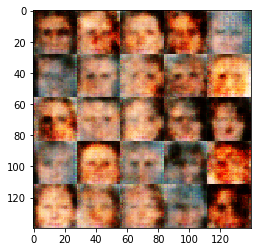

Estimated time remaining of epoch: 0:14:42.491468
Epoch 1/1...    9.6%  Discriminator Loss: 0.4945... Generator Loss: 3.1295
Epoch 1/1...    9.8%  Discriminator Loss: 0.5904... Generator Loss: 2.8651
Epoch 1/1...    9.9%  Discriminator Loss: 0.6661... Generator Loss: 1.7793
Epoch 1/1...   10.1%  Discriminator Loss: 0.5661... Generator Loss: 2.7524
Epoch 1/1...   10.3%  Discriminator Loss: 0.5799... Generator Loss: 2.5960
Epoch 1/1...   10.4%  Discriminator Loss: 0.4999... Generator Loss: 2.7611
Epoch 1/1...   10.6%  Discriminator Loss: 0.5310... Generator Loss: 3.1285
Epoch 1/1...   10.7%  Discriminator Loss: 0.5826... Generator Loss: 1.9993
Epoch 1/1...   10.9%  Discriminator Loss: 0.5537... Generator Loss: 2.3178
Epoch 1/1...   11.0%  Discriminator Loss: 0.4813... Generator Loss: 2.6750


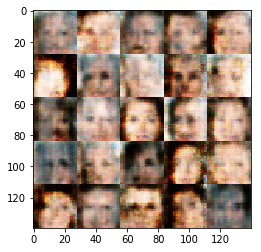

Estimated time remaining of epoch: 0:14:38.834471
Epoch 1/1...   11.2%  Discriminator Loss: 0.5742... Generator Loss: 2.9012
Epoch 1/1...   11.4%  Discriminator Loss: 0.5391... Generator Loss: 3.2284
Epoch 1/1...   11.5%  Discriminator Loss: 1.0570... Generator Loss: 0.9258
Epoch 1/1...   11.7%  Discriminator Loss: 0.8877... Generator Loss: 1.4170
Epoch 1/1...   11.8%  Discriminator Loss: 1.0808... Generator Loss: 0.9939
Epoch 1/1...   12.0%  Discriminator Loss: 0.4955... Generator Loss: 2.5927
Epoch 1/1...   12.1%  Discriminator Loss: 0.6120... Generator Loss: 2.4200
Epoch 1/1...   12.3%  Discriminator Loss: 0.5008... Generator Loss: 2.6948
Epoch 1/1...   12.5%  Discriminator Loss: 0.6506... Generator Loss: 2.1781
Epoch 1/1...   12.6%  Discriminator Loss: 0.6999... Generator Loss: 1.7921


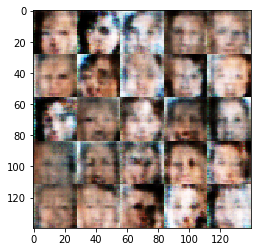

Estimated time remaining of epoch: 0:14:16.196206
Epoch 1/1...   12.8%  Discriminator Loss: 0.8879... Generator Loss: 1.0656
Epoch 1/1...   12.9%  Discriminator Loss: 0.6159... Generator Loss: 1.7922
Epoch 1/1...   13.1%  Discriminator Loss: 0.7145... Generator Loss: 1.5380
Epoch 1/1...   13.3%  Discriminator Loss: 0.6580... Generator Loss: 2.1592
Epoch 1/1...   13.4%  Discriminator Loss: 0.6901... Generator Loss: 2.6788
Epoch 1/1...   13.6%  Discriminator Loss: 0.6251... Generator Loss: 2.2517
Epoch 1/1...   13.7%  Discriminator Loss: 0.9546... Generator Loss: 1.3613
Epoch 1/1...   13.9%  Discriminator Loss: 0.7108... Generator Loss: 2.6985
Epoch 1/1...   14.0%  Discriminator Loss: 0.8935... Generator Loss: 1.5862
Epoch 1/1...   14.2%  Discriminator Loss: 1.0586... Generator Loss: 1.0182


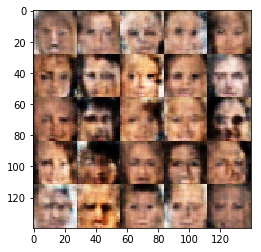

Estimated time remaining of epoch: 0:13:58.035390
Epoch 1/1...   14.4%  Discriminator Loss: 0.8534... Generator Loss: 2.5015
Epoch 1/1...   14.5%  Discriminator Loss: 0.6909... Generator Loss: 2.0071
Epoch 1/1...   14.7%  Discriminator Loss: 0.8464... Generator Loss: 1.4498
Epoch 1/1...   14.8%  Discriminator Loss: 0.9190... Generator Loss: 1.6593
Epoch 1/1...   15.0%  Discriminator Loss: 0.6896... Generator Loss: 1.6612
Epoch 1/1...   15.1%  Discriminator Loss: 0.9661... Generator Loss: 1.1590
Epoch 1/1...   15.3%  Discriminator Loss: 0.6393... Generator Loss: 2.1986
Epoch 1/1...   15.5%  Discriminator Loss: 0.6257... Generator Loss: 2.3476
Epoch 1/1...   15.6%  Discriminator Loss: 0.8109... Generator Loss: 3.3943
Epoch 1/1...   15.8%  Discriminator Loss: 0.7484... Generator Loss: 2.9084


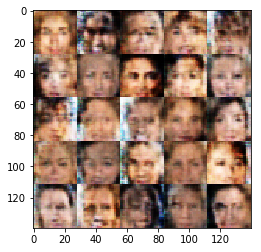

Estimated time remaining of epoch: 0:13:41.852101
Epoch 1/1...   15.9%  Discriminator Loss: 0.6872... Generator Loss: 2.1228
Epoch 1/1...   16.1%  Discriminator Loss: 0.7241... Generator Loss: 1.5716
Epoch 1/1...   16.3%  Discriminator Loss: 0.9181... Generator Loss: 3.0052
Epoch 1/1...   16.4%  Discriminator Loss: 0.7541... Generator Loss: 1.8224
Epoch 1/1...   16.6%  Discriminator Loss: 0.8505... Generator Loss: 1.7190
Epoch 1/1...   16.7%  Discriminator Loss: 0.6351... Generator Loss: 2.5505
Epoch 1/1...   16.9%  Discriminator Loss: 0.8322... Generator Loss: 2.3567
Epoch 1/1...   17.0%  Discriminator Loss: 0.9566... Generator Loss: 3.3721
Epoch 1/1...   17.2%  Discriminator Loss: 0.8602... Generator Loss: 2.6045
Epoch 1/1...   17.4%  Discriminator Loss: 0.8377... Generator Loss: 1.5532


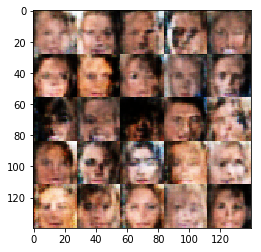

Estimated time remaining of epoch: 0:13:27.281226
Epoch 1/1...   17.5%  Discriminator Loss: 0.8695... Generator Loss: 2.9704
Epoch 1/1...   17.7%  Discriminator Loss: 0.6632... Generator Loss: 2.0780
Epoch 1/1...   17.8%  Discriminator Loss: 0.7345... Generator Loss: 1.9100
Epoch 1/1...   18.0%  Discriminator Loss: 0.8064... Generator Loss: 3.1268
Epoch 1/1...   18.1%  Discriminator Loss: 0.9909... Generator Loss: 1.3644
Epoch 1/1...   18.3%  Discriminator Loss: 0.8006... Generator Loss: 2.8228
Epoch 1/1...   18.5%  Discriminator Loss: 0.9700... Generator Loss: 1.1552
Epoch 1/1...   18.6%  Discriminator Loss: 0.6440... Generator Loss: 1.9269
Epoch 1/1...   18.8%  Discriminator Loss: 0.7653... Generator Loss: 2.0882
Epoch 1/1...   18.9%  Discriminator Loss: 0.7651... Generator Loss: 2.0709


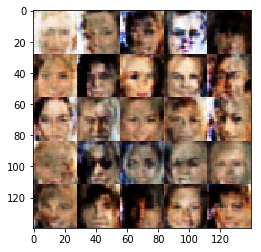

Estimated time remaining of epoch: 0:13:11.089733
Epoch 1/1...   19.1%  Discriminator Loss: 0.7241... Generator Loss: 2.3719
Epoch 1/1...   19.3%  Discriminator Loss: 0.6546... Generator Loss: 1.9585
Epoch 1/1...   19.4%  Discriminator Loss: 0.8514... Generator Loss: 1.8485
Epoch 1/1...   19.6%  Discriminator Loss: 0.8026... Generator Loss: 2.5473
Epoch 1/1...   19.7%  Discriminator Loss: 0.7718... Generator Loss: 1.3467
Epoch 1/1...   19.9%  Discriminator Loss: 0.7586... Generator Loss: 1.8039
Epoch 1/1...   20.0%  Discriminator Loss: 0.8064... Generator Loss: 1.3513
Epoch 1/1...   20.2%  Discriminator Loss: 0.7247... Generator Loss: 1.8406
Epoch 1/1...   20.4%  Discriminator Loss: 1.1007... Generator Loss: 2.6548
Epoch 1/1...   20.5%  Discriminator Loss: 0.8273... Generator Loss: 1.7391


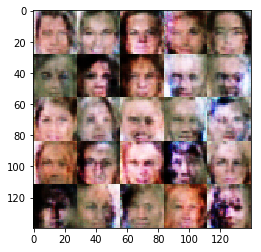

Estimated time remaining of epoch: 0:12:55.017759
Epoch 1/1...   20.7%  Discriminator Loss: 0.7096... Generator Loss: 1.8050
Epoch 1/1...   20.8%  Discriminator Loss: 0.6820... Generator Loss: 1.7485
Epoch 1/1...   21.0%  Discriminator Loss: 0.7416... Generator Loss: 1.9290
Epoch 1/1...   21.1%  Discriminator Loss: 0.6841... Generator Loss: 2.3383
Epoch 1/1...   21.3%  Discriminator Loss: 0.7759... Generator Loss: 1.9650
Epoch 1/1...   21.5%  Discriminator Loss: 1.0483... Generator Loss: 0.7599
Epoch 1/1...   21.6%  Discriminator Loss: 0.7712... Generator Loss: 1.8182
Epoch 1/1...   21.8%  Discriminator Loss: 0.6207... Generator Loss: 2.4017
Epoch 1/1...   21.9%  Discriminator Loss: 1.0553... Generator Loss: 0.9707
Epoch 1/1...   22.1%  Discriminator Loss: 0.8919... Generator Loss: 1.9457


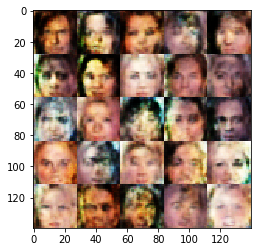

Estimated time remaining of epoch: 0:12:39.073575
Epoch 1/1...   22.3%  Discriminator Loss: 0.7569... Generator Loss: 1.4285
Epoch 1/1...   22.4%  Discriminator Loss: 0.8777... Generator Loss: 1.5539
Epoch 1/1...   22.6%  Discriminator Loss: 0.7175... Generator Loss: 1.6873
Epoch 1/1...   22.7%  Discriminator Loss: 0.7218... Generator Loss: 1.8274
Epoch 1/1...   22.9%  Discriminator Loss: 0.6538... Generator Loss: 1.6048
Epoch 1/1...   23.0%  Discriminator Loss: 0.6550... Generator Loss: 2.4501
Epoch 1/1...   23.2%  Discriminator Loss: 0.6329... Generator Loss: 1.7067
Epoch 1/1...   23.4%  Discriminator Loss: 0.8536... Generator Loss: 1.6365
Epoch 1/1...   23.5%  Discriminator Loss: 0.6843... Generator Loss: 1.5982
Epoch 1/1...   23.7%  Discriminator Loss: 0.6146... Generator Loss: 2.1045


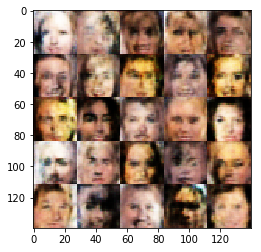

Estimated time remaining of epoch: 0:12:25.165432
Epoch 1/1...   23.8%  Discriminator Loss: 0.8677... Generator Loss: 1.8344
Epoch 1/1...   24.0%  Discriminator Loss: 1.0995... Generator Loss: 0.8671
Epoch 1/1...   24.2%  Discriminator Loss: 0.8188... Generator Loss: 1.4756
Epoch 1/1...   24.3%  Discriminator Loss: 0.7078... Generator Loss: 2.1423
Epoch 1/1...   24.5%  Discriminator Loss: 0.7260... Generator Loss: 1.8186
Epoch 1/1...   24.6%  Discriminator Loss: 0.9950... Generator Loss: 1.0260
Epoch 1/1...   24.8%  Discriminator Loss: 0.5842... Generator Loss: 2.1688
Epoch 1/1...   24.9%  Discriminator Loss: 0.9518... Generator Loss: 1.3594
Epoch 1/1...   25.1%  Discriminator Loss: 0.6934... Generator Loss: 1.6294
Epoch 1/1...   25.3%  Discriminator Loss: 0.8325... Generator Loss: 1.5899


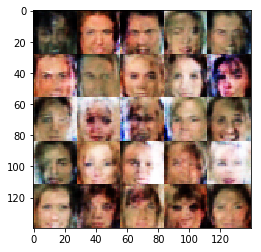

Estimated time remaining of epoch: 0:12:09.279372
Epoch 1/1...   25.4%  Discriminator Loss: 0.6542... Generator Loss: 1.8829
Epoch 1/1...   25.6%  Discriminator Loss: 0.8868... Generator Loss: 1.4141
Epoch 1/1...   25.7%  Discriminator Loss: 0.8780... Generator Loss: 1.2613
Epoch 1/1...   25.9%  Discriminator Loss: 0.8300... Generator Loss: 1.3333
Epoch 1/1...   26.0%  Discriminator Loss: 0.6870... Generator Loss: 1.9165
Epoch 1/1...   26.2%  Discriminator Loss: 0.6990... Generator Loss: 1.6268
Epoch 1/1...   26.4%  Discriminator Loss: 0.6603... Generator Loss: 2.0344
Epoch 1/1...   26.5%  Discriminator Loss: 0.7131... Generator Loss: 3.2662
Epoch 1/1...   26.7%  Discriminator Loss: 0.6799... Generator Loss: 1.8955
Epoch 1/1...   26.8%  Discriminator Loss: 0.6029... Generator Loss: 2.7594


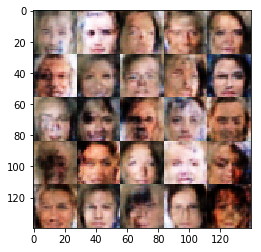

Estimated time remaining of epoch: 0:12:01.186786
Epoch 1/1...   27.0%  Discriminator Loss: 0.8249... Generator Loss: 1.3133
Epoch 1/1...   27.2%  Discriminator Loss: 0.9834... Generator Loss: 1.0976
Epoch 1/1...   27.3%  Discriminator Loss: 0.6507... Generator Loss: 2.2008
Epoch 1/1...   27.5%  Discriminator Loss: 0.6527... Generator Loss: 1.9202
Epoch 1/1...   27.6%  Discriminator Loss: 0.6999... Generator Loss: 2.2981
Epoch 1/1...   27.8%  Discriminator Loss: 0.7638... Generator Loss: 2.2828
Epoch 1/1...   27.9%  Discriminator Loss: 0.9398... Generator Loss: 1.6221
Epoch 1/1...   28.1%  Discriminator Loss: 0.6938... Generator Loss: 2.1151
Epoch 1/1...   28.3%  Discriminator Loss: 0.7413... Generator Loss: 2.6963
Epoch 1/1...   28.4%  Discriminator Loss: 0.6110... Generator Loss: 2.9311


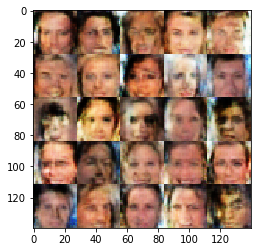

Estimated time remaining of epoch: 0:11:38.505173
Epoch 1/1...   28.6%  Discriminator Loss: 0.8302... Generator Loss: 1.5620
Epoch 1/1...   28.7%  Discriminator Loss: 0.6618... Generator Loss: 2.3680
Epoch 1/1...   28.9%  Discriminator Loss: 0.8762... Generator Loss: 1.5774
Epoch 1/1...   29.0%  Discriminator Loss: 0.7186... Generator Loss: 2.2340
Epoch 1/1...   29.2%  Discriminator Loss: 0.7234... Generator Loss: 1.9604
Epoch 1/1...   29.4%  Discriminator Loss: 0.6908... Generator Loss: 2.5730
Epoch 1/1...   29.5%  Discriminator Loss: 0.8783... Generator Loss: 1.3978
Epoch 1/1...   29.7%  Discriminator Loss: 1.2711... Generator Loss: 2.7806
Epoch 1/1...   29.8%  Discriminator Loss: 0.6758... Generator Loss: 1.6534
Epoch 1/1...   30.0%  Discriminator Loss: 0.8066... Generator Loss: 1.2619


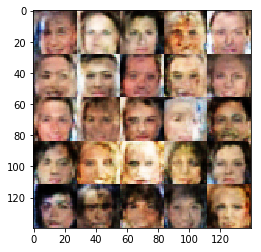

Estimated time remaining of epoch: 0:11:23.853789
Epoch 1/1...   30.2%  Discriminator Loss: 0.6782... Generator Loss: 1.9608
Epoch 1/1...   30.3%  Discriminator Loss: 0.8265... Generator Loss: 2.3122
Epoch 1/1...   30.5%  Discriminator Loss: 0.7276... Generator Loss: 2.4872
Epoch 1/1...   30.6%  Discriminator Loss: 0.7019... Generator Loss: 2.4950
Epoch 1/1...   30.8%  Discriminator Loss: 0.6128... Generator Loss: 1.8352
Epoch 1/1...   30.9%  Discriminator Loss: 0.6124... Generator Loss: 2.2786
Epoch 1/1...   31.1%  Discriminator Loss: 0.6798... Generator Loss: 2.2681
Epoch 1/1...   31.3%  Discriminator Loss: 0.6474... Generator Loss: 2.5169
Epoch 1/1...   31.4%  Discriminator Loss: 0.7138... Generator Loss: 3.5205
Epoch 1/1...   31.6%  Discriminator Loss: 0.9822... Generator Loss: 0.7725


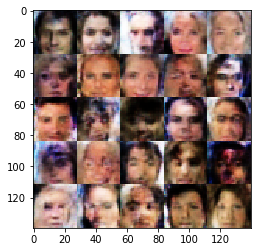

Estimated time remaining of epoch: 0:11:07.820811
Epoch 1/1...   31.7%  Discriminator Loss: 0.7807... Generator Loss: 1.9209
Epoch 1/1...   31.9%  Discriminator Loss: 0.7705... Generator Loss: 1.8161
Epoch 1/1...   32.0%  Discriminator Loss: 0.7008... Generator Loss: 3.2616
Epoch 1/1...   32.2%  Discriminator Loss: 0.8732... Generator Loss: 1.5743
Epoch 1/1...   32.4%  Discriminator Loss: 0.7725... Generator Loss: 2.0763
Epoch 1/1...   32.5%  Discriminator Loss: 0.8102... Generator Loss: 1.0628
Epoch 1/1...   32.7%  Discriminator Loss: 0.9970... Generator Loss: 1.2561
Epoch 1/1...   32.8%  Discriminator Loss: 0.7087... Generator Loss: 2.0560
Epoch 1/1...   33.0%  Discriminator Loss: 0.6455... Generator Loss: 2.0539
Epoch 1/1...   33.2%  Discriminator Loss: 0.6627... Generator Loss: 2.5597


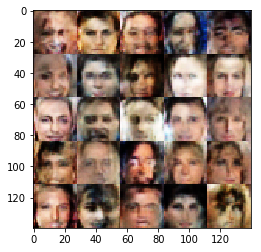

Estimated time remaining of epoch: 0:10:54.370684
Epoch 1/1...   33.3%  Discriminator Loss: 0.6496... Generator Loss: 2.1828
Epoch 1/1...   33.5%  Discriminator Loss: 0.8438... Generator Loss: 1.6640
Epoch 1/1...   33.6%  Discriminator Loss: 0.7250... Generator Loss: 2.4621
Epoch 1/1...   33.8%  Discriminator Loss: 0.7792... Generator Loss: 3.7051
Epoch 1/1...   33.9%  Discriminator Loss: 0.6859... Generator Loss: 1.7750
Epoch 1/1...   34.1%  Discriminator Loss: 0.7238... Generator Loss: 1.1519
Epoch 1/1...   34.3%  Discriminator Loss: 0.7564... Generator Loss: 1.2803
Epoch 1/1...   34.4%  Discriminator Loss: 0.7858... Generator Loss: 1.5119
Epoch 1/1...   34.6%  Discriminator Loss: 0.7924... Generator Loss: 2.2136
Epoch 1/1...   34.7%  Discriminator Loss: 0.5972... Generator Loss: 1.9615


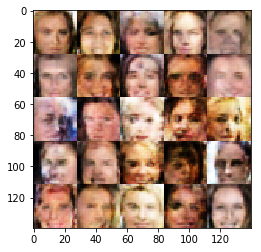

Estimated time remaining of epoch: 0:10:40.609984
Epoch 1/1...   34.9%  Discriminator Loss: 1.1662... Generator Loss: 0.7687
Epoch 1/1...   35.0%  Discriminator Loss: 0.6606... Generator Loss: 1.7038
Epoch 1/1...   35.2%  Discriminator Loss: 0.5298... Generator Loss: 2.3429
Epoch 1/1...   35.4%  Discriminator Loss: 0.7594... Generator Loss: 1.4437
Epoch 1/1...   35.5%  Discriminator Loss: 0.6470... Generator Loss: 1.7809
Epoch 1/1...   35.7%  Discriminator Loss: 0.8259... Generator Loss: 2.2858
Epoch 1/1...   35.8%  Discriminator Loss: 0.8290... Generator Loss: 1.4026
Epoch 1/1...   36.0%  Discriminator Loss: 0.5998... Generator Loss: 2.4243
Epoch 1/1...   36.2%  Discriminator Loss: 0.8475... Generator Loss: 1.2070
Epoch 1/1...   36.3%  Discriminator Loss: 0.5553... Generator Loss: 2.3864


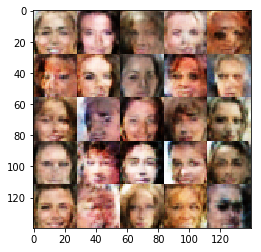

Estimated time remaining of epoch: 0:10:22.851886
Epoch 1/1...   36.5%  Discriminator Loss: 1.7594... Generator Loss: 0.4728
Epoch 1/1...   36.6%  Discriminator Loss: 0.6603... Generator Loss: 2.2413
Epoch 1/1...   36.8%  Discriminator Loss: 0.8217... Generator Loss: 1.5036
Epoch 1/1...   36.9%  Discriminator Loss: 0.7457... Generator Loss: 1.9736
Epoch 1/1...   37.1%  Discriminator Loss: 0.6317... Generator Loss: 2.5101
Epoch 1/1...   37.3%  Discriminator Loss: 0.5606... Generator Loss: 3.1463
Epoch 1/1...   37.4%  Discriminator Loss: 0.7987... Generator Loss: 1.4433
Epoch 1/1...   37.6%  Discriminator Loss: 0.8180... Generator Loss: 2.1554
Epoch 1/1...   37.7%  Discriminator Loss: 0.7201... Generator Loss: 2.2280
Epoch 1/1...   37.9%  Discriminator Loss: 0.6153... Generator Loss: 2.3390


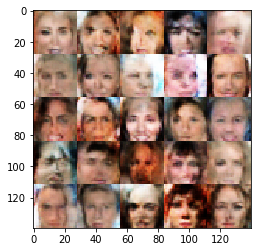

Estimated time remaining of epoch: 0:10:08.402900
Epoch 1/1...   38.1%  Discriminator Loss: 0.9516... Generator Loss: 1.0662
Epoch 1/1...   38.2%  Discriminator Loss: 0.9002... Generator Loss: 2.7326
Epoch 1/1...   38.4%  Discriminator Loss: 1.0474... Generator Loss: 0.7609
Epoch 1/1...   38.5%  Discriminator Loss: 1.1573... Generator Loss: 0.5788
Epoch 1/1...   38.7%  Discriminator Loss: 0.7426... Generator Loss: 1.9315
Epoch 1/1...   38.8%  Discriminator Loss: 0.7204... Generator Loss: 1.2900
Epoch 1/1...   39.0%  Discriminator Loss: 0.7269... Generator Loss: 2.4128
Epoch 1/1...   39.2%  Discriminator Loss: 0.6011... Generator Loss: 1.6109
Epoch 1/1...   39.3%  Discriminator Loss: 0.7099... Generator Loss: 1.9185
Epoch 1/1...   39.5%  Discriminator Loss: 0.5520... Generator Loss: 2.1717


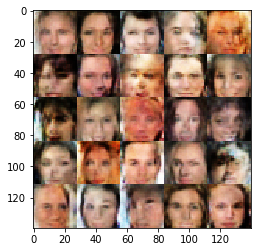

Estimated time remaining of epoch: 0:09:53.161233
Epoch 1/1...   39.6%  Discriminator Loss: 0.9823... Generator Loss: 1.8289
Epoch 1/1...   39.8%  Discriminator Loss: 0.9353... Generator Loss: 1.3802
Epoch 1/1...   39.9%  Discriminator Loss: 0.6468... Generator Loss: 2.1024
Epoch 1/1...   40.1%  Discriminator Loss: 0.5927... Generator Loss: 1.9001
Epoch 1/1...   40.3%  Discriminator Loss: 0.6787... Generator Loss: 1.7623
Epoch 1/1...   40.4%  Discriminator Loss: 0.6694... Generator Loss: 1.6317
Epoch 1/1...   40.6%  Discriminator Loss: 0.6118... Generator Loss: 2.6338
Epoch 1/1...   40.7%  Discriminator Loss: 0.6562... Generator Loss: 1.4196
Epoch 1/1...   40.9%  Discriminator Loss: 0.7045... Generator Loss: 1.6136
Epoch 1/1...   41.1%  Discriminator Loss: 0.6737... Generator Loss: 1.9081


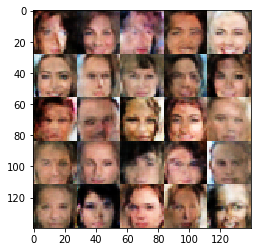

Estimated time remaining of epoch: 0:09:36.317084
Epoch 1/1...   41.2%  Discriminator Loss: 0.6783... Generator Loss: 2.1901
Epoch 1/1...   41.4%  Discriminator Loss: 0.5906... Generator Loss: 1.6666
Epoch 1/1...   41.5%  Discriminator Loss: 0.5779... Generator Loss: 2.4325
Epoch 1/1...   41.7%  Discriminator Loss: 0.6982... Generator Loss: 1.8610
Epoch 1/1...   41.8%  Discriminator Loss: 0.6690... Generator Loss: 1.6512
Epoch 1/1...   42.0%  Discriminator Loss: 1.1669... Generator Loss: 1.0166
Epoch 1/1...   42.2%  Discriminator Loss: 0.5307... Generator Loss: 2.4857
Epoch 1/1...   42.3%  Discriminator Loss: 0.6873... Generator Loss: 1.9828
Epoch 1/1...   42.5%  Discriminator Loss: 0.6231... Generator Loss: 2.6816
Epoch 1/1...   42.6%  Discriminator Loss: 0.5924... Generator Loss: 2.6856


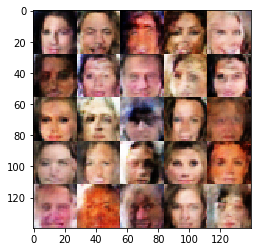

Estimated time remaining of epoch: 0:09:27.352292
Epoch 1/1...   42.8%  Discriminator Loss: 0.8625... Generator Loss: 0.9895
Epoch 1/1...   42.9%  Discriminator Loss: 0.5213... Generator Loss: 2.5372
Epoch 1/1...   43.1%  Discriminator Loss: 0.6774... Generator Loss: 1.6644
Epoch 1/1...   43.3%  Discriminator Loss: 0.6528... Generator Loss: 2.0841
Epoch 1/1...   43.4%  Discriminator Loss: 0.7671... Generator Loss: 1.4973
Epoch 1/1...   43.6%  Discriminator Loss: 0.9090... Generator Loss: 1.1277
Epoch 1/1...   43.7%  Discriminator Loss: 0.6812... Generator Loss: 1.6385
Epoch 1/1...   43.9%  Discriminator Loss: 0.7483... Generator Loss: 2.1793
Epoch 1/1...   44.1%  Discriminator Loss: 0.5451... Generator Loss: 2.3407
Epoch 1/1...   44.2%  Discriminator Loss: 0.6076... Generator Loss: 2.8223


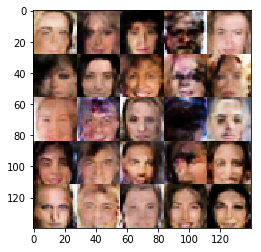

Estimated time remaining of epoch: 0:09:08.121183
Epoch 1/1...   44.4%  Discriminator Loss: 0.7116... Generator Loss: 1.5122
Epoch 1/1...   44.5%  Discriminator Loss: 0.6490... Generator Loss: 2.2041
Epoch 1/1...   44.7%  Discriminator Loss: 0.7958... Generator Loss: 1.7254
Epoch 1/1...   44.8%  Discriminator Loss: 0.6505... Generator Loss: 2.2623
Epoch 1/1...   45.0%  Discriminator Loss: 0.6123... Generator Loss: 1.9533
Epoch 1/1...   45.2%  Discriminator Loss: 0.6640... Generator Loss: 2.1777
Epoch 1/1...   45.3%  Discriminator Loss: 0.5146... Generator Loss: 2.7454
Epoch 1/1...   45.5%  Discriminator Loss: 0.6912... Generator Loss: 1.2971
Epoch 1/1...   45.6%  Discriminator Loss: 0.6403... Generator Loss: 2.5469
Epoch 1/1...   45.8%  Discriminator Loss: 0.7655... Generator Loss: 1.9649


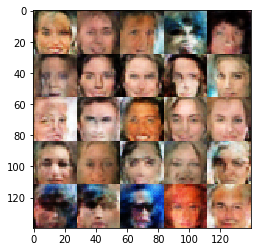

Estimated time remaining of epoch: 0:08:50.365999
Epoch 1/1...   45.9%  Discriminator Loss: 0.7812... Generator Loss: 2.3955
Epoch 1/1...   46.1%  Discriminator Loss: 0.9740... Generator Loss: 1.0201
Epoch 1/1...   46.3%  Discriminator Loss: 1.1187... Generator Loss: 0.8820
Epoch 1/1...   46.4%  Discriminator Loss: 0.6304... Generator Loss: 2.6450
Epoch 1/1...   46.6%  Discriminator Loss: 0.6463... Generator Loss: 2.6525
Epoch 1/1...   46.7%  Discriminator Loss: 0.6573... Generator Loss: 1.5468
Epoch 1/1...   46.9%  Discriminator Loss: 0.6409... Generator Loss: 2.1903
Epoch 1/1...   47.1%  Discriminator Loss: 0.5355... Generator Loss: 2.7887
Epoch 1/1...   47.2%  Discriminator Loss: 0.7416... Generator Loss: 1.6715
Epoch 1/1...   47.4%  Discriminator Loss: 0.6936... Generator Loss: 2.2041


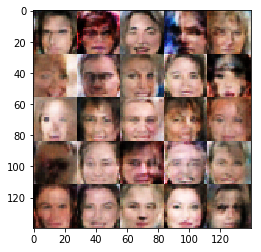

Estimated time remaining of epoch: 0:08:35.588591
Epoch 1/1...   47.5%  Discriminator Loss: 0.5740... Generator Loss: 2.0930
Epoch 1/1...   47.7%  Discriminator Loss: 0.6457... Generator Loss: 1.7669
Epoch 1/1...   47.8%  Discriminator Loss: 0.7345... Generator Loss: 1.7146
Epoch 1/1...   48.0%  Discriminator Loss: 0.5779... Generator Loss: 2.3160
Epoch 1/1...   48.2%  Discriminator Loss: 0.6121... Generator Loss: 2.9898
Epoch 1/1...   48.3%  Discriminator Loss: 0.7766... Generator Loss: 1.6266
Epoch 1/1...   48.5%  Discriminator Loss: 0.6322... Generator Loss: 1.9681
Epoch 1/1...   48.6%  Discriminator Loss: 0.8858... Generator Loss: 3.6177
Epoch 1/1...   48.8%  Discriminator Loss: 0.7626... Generator Loss: 2.1164
Epoch 1/1...   48.9%  Discriminator Loss: 0.7410... Generator Loss: 2.2270


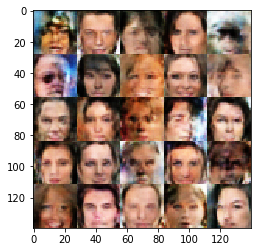

Estimated time remaining of epoch: 0:08:19.975361
Epoch 1/1...   49.1%  Discriminator Loss: 0.6413... Generator Loss: 1.8764
Epoch 1/1...   49.3%  Discriminator Loss: 0.7037... Generator Loss: 1.3614
Epoch 1/1...   49.4%  Discriminator Loss: 0.6987... Generator Loss: 2.2652
Epoch 1/1...   49.6%  Discriminator Loss: 0.5483... Generator Loss: 1.8646
Epoch 1/1...   49.7%  Discriminator Loss: 0.8693... Generator Loss: 2.3394
Epoch 1/1...   49.9%  Discriminator Loss: 1.2705... Generator Loss: 0.5823
Epoch 1/1...   50.1%  Discriminator Loss: 0.6058... Generator Loss: 2.0720
Epoch 1/1...   50.2%  Discriminator Loss: 0.8537... Generator Loss: 1.2892
Epoch 1/1...   50.4%  Discriminator Loss: 0.7289... Generator Loss: 1.8000
Epoch 1/1...   50.5%  Discriminator Loss: 0.6165... Generator Loss: 2.2286


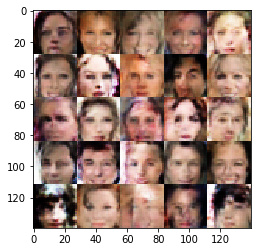

Estimated time remaining of epoch: 0:08:06.400808
Epoch 1/1...   50.7%  Discriminator Loss: 0.6535... Generator Loss: 1.4829
Epoch 1/1...   50.8%  Discriminator Loss: 0.7090... Generator Loss: 1.9789
Epoch 1/1...   51.0%  Discriminator Loss: 0.6063... Generator Loss: 2.3005
Epoch 1/1...   51.2%  Discriminator Loss: 0.6516... Generator Loss: 2.1043
Epoch 1/1...   51.3%  Discriminator Loss: 0.7312... Generator Loss: 2.7074
Epoch 1/1...   51.5%  Discriminator Loss: 0.8445... Generator Loss: 0.9954
Epoch 1/1...   51.6%  Discriminator Loss: 0.7844... Generator Loss: 1.7404
Epoch 1/1...   51.8%  Discriminator Loss: 0.8303... Generator Loss: 1.2961
Epoch 1/1...   52.0%  Discriminator Loss: 0.9603... Generator Loss: 0.9197
Epoch 1/1...   52.1%  Discriminator Loss: 0.7089... Generator Loss: 1.8134


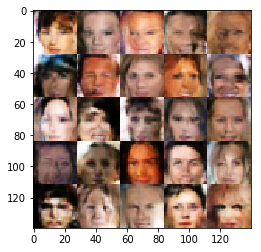

Estimated time remaining of epoch: 0:07:49.284218
Epoch 1/1...   52.3%  Discriminator Loss: 0.8624... Generator Loss: 1.2925
Epoch 1/1...   52.4%  Discriminator Loss: 0.6013... Generator Loss: 3.8301
Epoch 1/1...   52.6%  Discriminator Loss: 0.8086... Generator Loss: 1.9550
Epoch 1/1...   52.7%  Discriminator Loss: 0.6182... Generator Loss: 2.0959
Epoch 1/1...   52.9%  Discriminator Loss: 0.6464... Generator Loss: 1.8431
Epoch 1/1...   53.1%  Discriminator Loss: 0.5886... Generator Loss: 1.8925
Epoch 1/1...   53.2%  Discriminator Loss: 0.7074... Generator Loss: 1.7996
Epoch 1/1...   53.4%  Discriminator Loss: 0.6100... Generator Loss: 2.6310
Epoch 1/1...   53.5%  Discriminator Loss: 0.7698... Generator Loss: 1.5134
Epoch 1/1...   53.7%  Discriminator Loss: 0.6284... Generator Loss: 1.9295


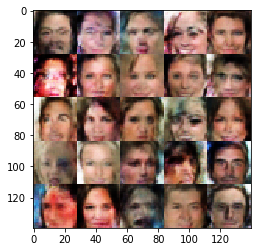

Estimated time remaining of epoch: 0:07:33.205052
Epoch 1/1...   53.8%  Discriminator Loss: 0.6945... Generator Loss: 2.1686
Epoch 1/1...   54.0%  Discriminator Loss: 0.8770... Generator Loss: 3.0542
Epoch 1/1...   54.2%  Discriminator Loss: 0.9402... Generator Loss: 1.1360
Epoch 1/1...   54.3%  Discriminator Loss: 1.0110... Generator Loss: 0.9746
Epoch 1/1...   54.5%  Discriminator Loss: 0.7500... Generator Loss: 1.5106
Epoch 1/1...   54.6%  Discriminator Loss: 0.5717... Generator Loss: 2.7672
Epoch 1/1...   54.8%  Discriminator Loss: 0.6433... Generator Loss: 1.7295
Epoch 1/1...   55.0%  Discriminator Loss: 0.6696... Generator Loss: 3.4752
Epoch 1/1...   55.1%  Discriminator Loss: 0.5728... Generator Loss: 1.9515
Epoch 1/1...   55.3%  Discriminator Loss: 0.8503... Generator Loss: 1.3928


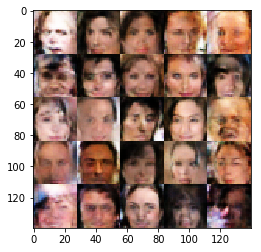

Estimated time remaining of epoch: 0:07:18.107858
Epoch 1/1...   55.4%  Discriminator Loss: 0.5502... Generator Loss: 2.7705
Epoch 1/1...   55.6%  Discriminator Loss: 0.6878... Generator Loss: 2.0680
Epoch 1/1...   55.7%  Discriminator Loss: 0.6147... Generator Loss: 1.6733
Epoch 1/1...   55.9%  Discriminator Loss: 0.8754... Generator Loss: 1.3132
Epoch 1/1...   56.1%  Discriminator Loss: 0.5494... Generator Loss: 2.4464
Epoch 1/1...   56.2%  Discriminator Loss: 0.5603... Generator Loss: 3.2546
Epoch 1/1...   56.4%  Discriminator Loss: 0.7636... Generator Loss: 1.5118
Epoch 1/1...   56.5%  Discriminator Loss: 0.6643... Generator Loss: 2.1101
Epoch 1/1...   56.7%  Discriminator Loss: 0.6726... Generator Loss: 1.2706
Epoch 1/1...   56.8%  Discriminator Loss: 0.6447... Generator Loss: 2.4830


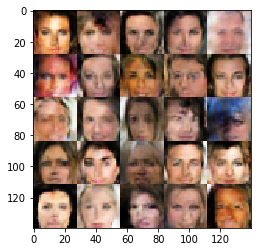

Estimated time remaining of epoch: 0:07:03.394069
Epoch 1/1...   57.0%  Discriminator Loss: 0.6605... Generator Loss: 1.4543
Epoch 1/1...   57.2%  Discriminator Loss: 0.9243... Generator Loss: 1.2226
Epoch 1/1...   57.3%  Discriminator Loss: 0.7117... Generator Loss: 2.8785
Epoch 1/1...   57.5%  Discriminator Loss: 0.5593... Generator Loss: 1.9386
Epoch 1/1...   57.6%  Discriminator Loss: 0.7252... Generator Loss: 1.6074
Epoch 1/1...   57.8%  Discriminator Loss: 0.6991... Generator Loss: 1.6201
Epoch 1/1...   58.0%  Discriminator Loss: 0.5693... Generator Loss: 1.7664
Epoch 1/1...   58.1%  Discriminator Loss: 0.8015... Generator Loss: 1.3142
Epoch 1/1...   58.3%  Discriminator Loss: 0.5595... Generator Loss: 2.4997
Epoch 1/1...   58.4%  Discriminator Loss: 0.7312... Generator Loss: 1.6542


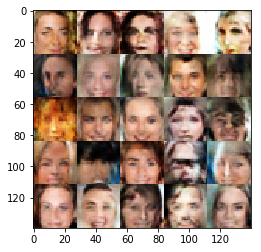

Estimated time remaining of epoch: 0:06:47.493653
Epoch 1/1...   58.6%  Discriminator Loss: 0.5703... Generator Loss: 3.0374
Epoch 1/1...   58.7%  Discriminator Loss: 0.9001... Generator Loss: 1.3422
Epoch 1/1...   58.9%  Discriminator Loss: 0.6113... Generator Loss: 2.1856
Epoch 1/1...   59.1%  Discriminator Loss: 0.7243... Generator Loss: 1.4705
Epoch 1/1...   59.2%  Discriminator Loss: 0.9490... Generator Loss: 2.9914
Epoch 1/1...   59.4%  Discriminator Loss: 0.6913... Generator Loss: 1.9071
Epoch 1/1...   59.5%  Discriminator Loss: 1.2082... Generator Loss: 1.0379
Epoch 1/1...   59.7%  Discriminator Loss: 0.6027... Generator Loss: 2.3785
Epoch 1/1...   59.8%  Discriminator Loss: 1.0310... Generator Loss: 0.8842
Epoch 1/1...   60.0%  Discriminator Loss: 0.7058... Generator Loss: 2.2183


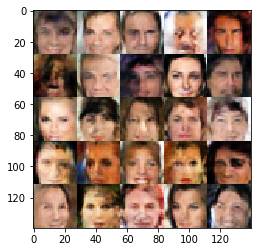

Estimated time remaining of epoch: 0:06:31.722831
Epoch 1/1...   60.2%  Discriminator Loss: 0.8188... Generator Loss: 1.2600
Epoch 1/1...   60.3%  Discriminator Loss: 0.6130... Generator Loss: 1.8512
Epoch 1/1...   60.5%  Discriminator Loss: 0.7134... Generator Loss: 1.8060
Epoch 1/1...   60.6%  Discriminator Loss: 0.5756... Generator Loss: 1.7734
Epoch 1/1...   60.8%  Discriminator Loss: 0.5812... Generator Loss: 2.2424
Epoch 1/1...   61.0%  Discriminator Loss: 0.8598... Generator Loss: 1.1529
Epoch 1/1...   61.1%  Discriminator Loss: 0.7980... Generator Loss: 1.5747
Epoch 1/1...   61.3%  Discriminator Loss: 0.7035... Generator Loss: 2.0688
Epoch 1/1...   61.4%  Discriminator Loss: 0.5052... Generator Loss: 2.0579
Epoch 1/1...   61.6%  Discriminator Loss: 0.6893... Generator Loss: 2.2270


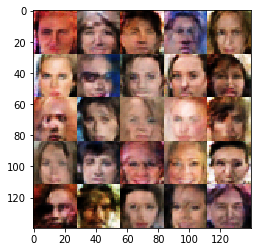

Estimated time remaining of epoch: 0:06:16.726259
Epoch 1/1...   61.7%  Discriminator Loss: 0.5855... Generator Loss: 2.0324
Epoch 1/1...   61.9%  Discriminator Loss: 0.7043... Generator Loss: 3.1681
Epoch 1/1...   62.1%  Discriminator Loss: 0.5245... Generator Loss: 2.4434
Epoch 1/1...   62.2%  Discriminator Loss: 0.7061... Generator Loss: 1.6832
Epoch 1/1...   62.4%  Discriminator Loss: 0.8223... Generator Loss: 1.8584
Epoch 1/1...   62.5%  Discriminator Loss: 0.7852... Generator Loss: 1.4411
Epoch 1/1...   62.7%  Discriminator Loss: 0.8173... Generator Loss: 1.3646
Epoch 1/1...   62.8%  Discriminator Loss: 0.8680... Generator Loss: 1.2723
Epoch 1/1...   63.0%  Discriminator Loss: 0.8668... Generator Loss: 0.8230
Epoch 1/1...   63.2%  Discriminator Loss: 0.5830... Generator Loss: 2.2251


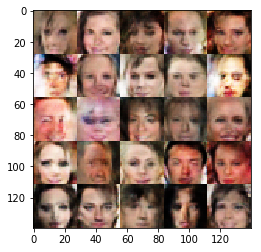

Estimated time remaining of epoch: 0:06:06.488636
Epoch 1/1...   63.3%  Discriminator Loss: 0.7334... Generator Loss: 2.1786
Epoch 1/1...   63.5%  Discriminator Loss: 0.7920... Generator Loss: 2.4540
Epoch 1/1...   63.6%  Discriminator Loss: 0.5944... Generator Loss: 3.0349
Epoch 1/1...   63.8%  Discriminator Loss: 0.7429... Generator Loss: 1.8755
Epoch 1/1...   64.0%  Discriminator Loss: 0.7070... Generator Loss: 2.1985
Epoch 1/1...   64.1%  Discriminator Loss: 0.7458... Generator Loss: 1.6998
Epoch 1/1...   64.3%  Discriminator Loss: 0.5055... Generator Loss: 2.6393
Epoch 1/1...   64.4%  Discriminator Loss: 0.4949... Generator Loss: 3.9829
Epoch 1/1...   64.6%  Discriminator Loss: 0.5121... Generator Loss: 2.3282
Epoch 1/1...   64.7%  Discriminator Loss: 0.5380... Generator Loss: 2.7877


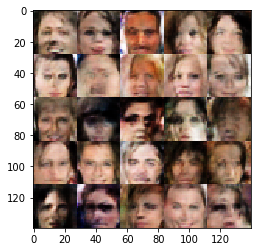

Estimated time remaining of epoch: 0:05:45.660351
Epoch 1/1...   64.9%  Discriminator Loss: 0.7452... Generator Loss: 1.7462
Epoch 1/1...   65.1%  Discriminator Loss: 0.7788... Generator Loss: 1.5366
Epoch 1/1...   65.2%  Discriminator Loss: 0.6776... Generator Loss: 2.0274
Epoch 1/1...   65.4%  Discriminator Loss: 0.6318... Generator Loss: 2.2278
Epoch 1/1...   65.5%  Discriminator Loss: 0.5805... Generator Loss: 2.1059
Epoch 1/1...   65.7%  Discriminator Loss: 0.7779... Generator Loss: 1.2187
Epoch 1/1...   65.9%  Discriminator Loss: 0.6412... Generator Loss: 1.5287
Epoch 1/1...   66.0%  Discriminator Loss: 0.5076... Generator Loss: 2.3466
Epoch 1/1...   66.2%  Discriminator Loss: 0.7439... Generator Loss: 2.2029
Epoch 1/1...   66.3%  Discriminator Loss: 0.6704... Generator Loss: 2.6238


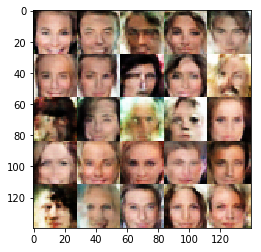

Estimated time remaining of epoch: 0:05:30.307375
Epoch 1/1...   66.5%  Discriminator Loss: 0.6039... Generator Loss: 2.2891
Epoch 1/1...   66.6%  Discriminator Loss: 0.6470... Generator Loss: 1.9371
Epoch 1/1...   66.8%  Discriminator Loss: 0.9140... Generator Loss: 1.7415
Epoch 1/1...   67.0%  Discriminator Loss: 0.5687... Generator Loss: 1.5317
Epoch 1/1...   67.1%  Discriminator Loss: 0.6936... Generator Loss: 3.3332
Epoch 1/1...   67.3%  Discriminator Loss: 0.5064... Generator Loss: 3.7588
Epoch 1/1...   67.4%  Discriminator Loss: 0.6693... Generator Loss: 2.0116
Epoch 1/1...   67.6%  Discriminator Loss: 0.5309... Generator Loss: 2.5623
Epoch 1/1...   67.7%  Discriminator Loss: 0.6367... Generator Loss: 2.1885
Epoch 1/1...   67.9%  Discriminator Loss: 0.8157... Generator Loss: 1.1660


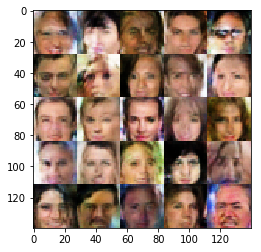

Estimated time remaining of epoch: 0:05:15.305329
Epoch 1/1...   68.1%  Discriminator Loss: 0.6330... Generator Loss: 2.0980
Epoch 1/1...   68.2%  Discriminator Loss: 0.6344... Generator Loss: 2.4772
Epoch 1/1...   68.4%  Discriminator Loss: 0.6066... Generator Loss: 2.1750
Epoch 1/1...   68.5%  Discriminator Loss: 0.5895... Generator Loss: 2.2074
Epoch 1/1...   68.7%  Discriminator Loss: 0.5465... Generator Loss: 2.3195
Epoch 1/1...   68.9%  Discriminator Loss: 0.6361... Generator Loss: 2.0193
Epoch 1/1...   69.0%  Discriminator Loss: 0.6946... Generator Loss: 2.0177
Epoch 1/1...   69.2%  Discriminator Loss: 0.6505... Generator Loss: 2.1165
Epoch 1/1...   69.3%  Discriminator Loss: 0.7573... Generator Loss: 2.9798
Epoch 1/1...   69.5%  Discriminator Loss: 0.5637... Generator Loss: 2.3580


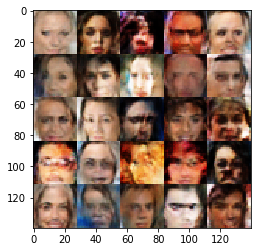

Estimated time remaining of epoch: 0:04:59.596312
Epoch 1/1...   69.6%  Discriminator Loss: 0.6096... Generator Loss: 1.6914
Epoch 1/1...   69.8%  Discriminator Loss: 0.6750... Generator Loss: 2.3011
Epoch 1/1...   70.0%  Discriminator Loss: 0.7498... Generator Loss: 2.0856
Epoch 1/1...   70.1%  Discriminator Loss: 0.4458... Generator Loss: 2.8714
Epoch 1/1...   70.3%  Discriminator Loss: 0.8065... Generator Loss: 1.2270
Epoch 1/1...   70.4%  Discriminator Loss: 0.6365... Generator Loss: 1.8469
Epoch 1/1...   70.6%  Discriminator Loss: 0.6186... Generator Loss: 1.6483
Epoch 1/1...   70.7%  Discriminator Loss: 0.6105... Generator Loss: 1.8016
Epoch 1/1...   70.9%  Discriminator Loss: 0.6962... Generator Loss: 1.7564
Epoch 1/1...   71.1%  Discriminator Loss: 0.8633... Generator Loss: 2.4439


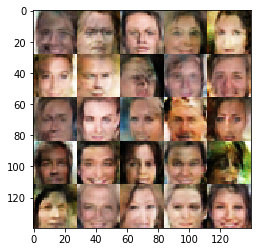

Estimated time remaining of epoch: 0:04:44.354488
Epoch 1/1...   71.2%  Discriminator Loss: 0.5946... Generator Loss: 2.5821
Epoch 1/1...   71.4%  Discriminator Loss: 0.7198... Generator Loss: 1.2274
Epoch 1/1...   71.5%  Discriminator Loss: 1.0824... Generator Loss: 3.1931
Epoch 1/1...   71.7%  Discriminator Loss: 0.5598... Generator Loss: 1.9216
Epoch 1/1...   71.9%  Discriminator Loss: 0.6119... Generator Loss: 2.2556
Epoch 1/1...   72.0%  Discriminator Loss: 0.7577... Generator Loss: 1.8643
Epoch 1/1...   72.2%  Discriminator Loss: 0.6647... Generator Loss: 2.7345
Epoch 1/1...   72.3%  Discriminator Loss: 0.5866... Generator Loss: 1.6995
Epoch 1/1...   72.5%  Discriminator Loss: 0.6190... Generator Loss: 2.0758
Epoch 1/1...   72.6%  Discriminator Loss: 0.7108... Generator Loss: 1.5289


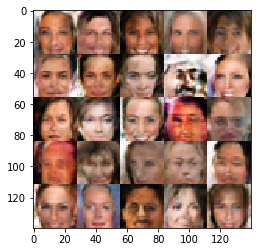

Estimated time remaining of epoch: 0:04:29.355707
Epoch 1/1...   72.8%  Discriminator Loss: 0.6158... Generator Loss: 2.3296
Epoch 1/1...   73.0%  Discriminator Loss: 0.5555... Generator Loss: 2.3763
Epoch 1/1...   73.1%  Discriminator Loss: 0.7838... Generator Loss: 2.0571
Epoch 1/1...   73.3%  Discriminator Loss: 0.6249... Generator Loss: 1.9050
Epoch 1/1...   73.4%  Discriminator Loss: 0.5655... Generator Loss: 1.9878
Epoch 1/1...   73.6%  Discriminator Loss: 0.7029... Generator Loss: 1.3436
Epoch 1/1...   73.7%  Discriminator Loss: 0.5107... Generator Loss: 3.0134
Epoch 1/1...   73.9%  Discriminator Loss: 0.6331... Generator Loss: 1.9187
Epoch 1/1...   74.1%  Discriminator Loss: 0.6236... Generator Loss: 1.6892
Epoch 1/1...   74.2%  Discriminator Loss: 0.7269... Generator Loss: 2.0228


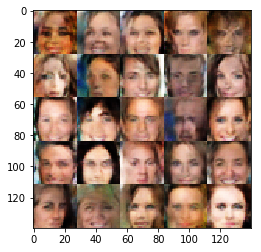

Estimated time remaining of epoch: 0:04:13.773557
Epoch 1/1...   74.4%  Discriminator Loss: 0.9687... Generator Loss: 0.9746
Epoch 1/1...   74.5%  Discriminator Loss: 0.5768... Generator Loss: 2.2041
Epoch 1/1...   74.7%  Discriminator Loss: 0.6569... Generator Loss: 2.7640
Epoch 1/1...   74.9%  Discriminator Loss: 0.6868... Generator Loss: 2.4566
Epoch 1/1...   75.0%  Discriminator Loss: 0.5855... Generator Loss: 3.0835
Epoch 1/1...   75.2%  Discriminator Loss: 0.6572... Generator Loss: 1.5027
Epoch 1/1...   75.3%  Discriminator Loss: 0.6182... Generator Loss: 1.9951
Epoch 1/1...   75.5%  Discriminator Loss: 0.7679... Generator Loss: 3.0971
Epoch 1/1...   75.6%  Discriminator Loss: 0.5307... Generator Loss: 2.4803
Epoch 1/1...   75.8%  Discriminator Loss: 1.1010... Generator Loss: 4.4160


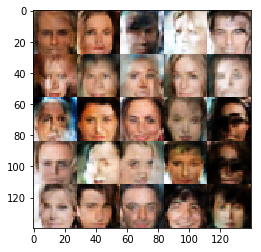

Estimated time remaining of epoch: 0:03:58.918438
Epoch 1/1...   76.0%  Discriminator Loss: 0.6290... Generator Loss: 1.8889
Epoch 1/1...   76.1%  Discriminator Loss: 0.6750... Generator Loss: 3.2487
Epoch 1/1...   76.3%  Discriminator Loss: 0.9372... Generator Loss: 1.4701
Epoch 1/1...   76.4%  Discriminator Loss: 0.4924... Generator Loss: 2.9189
Epoch 1/1...   76.6%  Discriminator Loss: 0.9374... Generator Loss: 1.3845
Epoch 1/1...   76.7%  Discriminator Loss: 0.6665... Generator Loss: 1.9024
Epoch 1/1...   76.9%  Discriminator Loss: 0.6708... Generator Loss: 1.6662
Epoch 1/1...   77.1%  Discriminator Loss: 0.6244... Generator Loss: 2.8130
Epoch 1/1...   77.2%  Discriminator Loss: 0.7671... Generator Loss: 1.2106
Epoch 1/1...   77.4%  Discriminator Loss: 0.6739... Generator Loss: 1.4896


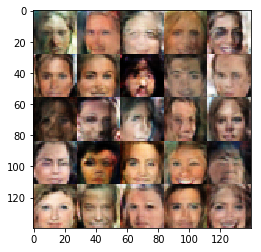

Estimated time remaining of epoch: 0:03:42.963101
Epoch 1/1...   77.5%  Discriminator Loss: 0.6920... Generator Loss: 1.2338
Epoch 1/1...   77.7%  Discriminator Loss: 1.2078... Generator Loss: 0.9406
Epoch 1/1...   77.9%  Discriminator Loss: 0.9408... Generator Loss: 1.2737
Epoch 1/1...   78.0%  Discriminator Loss: 0.7208... Generator Loss: 1.5627
Epoch 1/1...   78.2%  Discriminator Loss: 0.6604... Generator Loss: 1.3975
Epoch 1/1...   78.3%  Discriminator Loss: 0.4817... Generator Loss: 2.4023
Epoch 1/1...   78.5%  Discriminator Loss: 0.6580... Generator Loss: 1.5847
Epoch 1/1...   78.6%  Discriminator Loss: 0.5655... Generator Loss: 1.6560
Epoch 1/1...   78.8%  Discriminator Loss: 0.5739... Generator Loss: 2.9394
Epoch 1/1...   79.0%  Discriminator Loss: 0.6147... Generator Loss: 1.8761


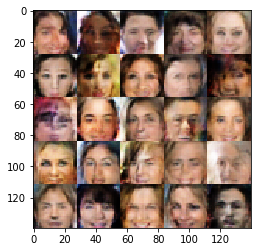

Estimated time remaining of epoch: 0:03:26.971261
Epoch 1/1...   79.1%  Discriminator Loss: 0.6122... Generator Loss: 2.3304
Epoch 1/1...   79.3%  Discriminator Loss: 0.5850... Generator Loss: 2.7403
Epoch 1/1...   79.4%  Discriminator Loss: 0.4384... Generator Loss: 3.3464
Epoch 1/1...   79.6%  Discriminator Loss: 0.6479... Generator Loss: 2.8259
Epoch 1/1...   79.8%  Discriminator Loss: 0.5339... Generator Loss: 2.4603
Epoch 1/1...   79.9%  Discriminator Loss: 0.4922... Generator Loss: 1.9931
Epoch 1/1...   80.1%  Discriminator Loss: 0.6670... Generator Loss: 1.9146
Epoch 1/1...   80.2%  Discriminator Loss: 0.7258... Generator Loss: 1.5995
Epoch 1/1...   80.4%  Discriminator Loss: 0.5880... Generator Loss: 1.7653
Epoch 1/1...   80.5%  Discriminator Loss: 0.6766... Generator Loss: 1.4991


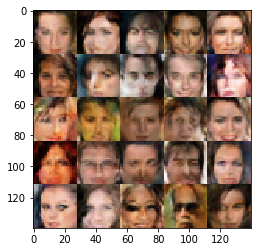

Estimated time remaining of epoch: 0:03:11.197582
Epoch 1/1...   80.7%  Discriminator Loss: 0.5683... Generator Loss: 2.1452
Epoch 1/1...   80.9%  Discriminator Loss: 0.5294... Generator Loss: 2.6832
Epoch 1/1...   81.0%  Discriminator Loss: 0.7641... Generator Loss: 1.2425
Epoch 1/1...   81.2%  Discriminator Loss: 0.7836... Generator Loss: 1.6330
Epoch 1/1...   81.3%  Discriminator Loss: 0.4614... Generator Loss: 2.8455
Epoch 1/1...   81.5%  Discriminator Loss: 0.5525... Generator Loss: 2.4999
Epoch 1/1...   81.6%  Discriminator Loss: 0.7723... Generator Loss: 1.3660
Epoch 1/1...   81.8%  Discriminator Loss: 0.7647... Generator Loss: 0.8693
Epoch 1/1...   82.0%  Discriminator Loss: 0.5449... Generator Loss: 2.5111
Epoch 1/1...   82.1%  Discriminator Loss: 0.5366... Generator Loss: 2.3122


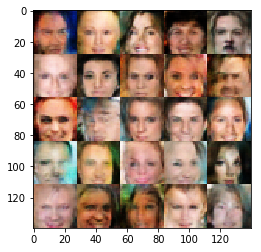

Estimated time remaining of epoch: 0:02:55.731841
Epoch 1/1...   82.3%  Discriminator Loss: 0.6175... Generator Loss: 1.7258
Epoch 1/1...   82.4%  Discriminator Loss: 0.5885... Generator Loss: 2.0504
Epoch 1/1...   82.6%  Discriminator Loss: 0.5052... Generator Loss: 1.9031
Epoch 1/1...   82.8%  Discriminator Loss: 0.4946... Generator Loss: 2.4232
Epoch 1/1...   82.9%  Discriminator Loss: 0.6700... Generator Loss: 1.2060
Epoch 1/1...   83.1%  Discriminator Loss: 0.6994... Generator Loss: 1.8641
Epoch 1/1...   83.2%  Discriminator Loss: 0.5939... Generator Loss: 2.0832
Epoch 1/1...   83.4%  Discriminator Loss: 0.7101... Generator Loss: 1.7678
Epoch 1/1...   83.5%  Discriminator Loss: 0.7814... Generator Loss: 2.9302
Epoch 1/1...   83.7%  Discriminator Loss: 0.7714... Generator Loss: 1.9010


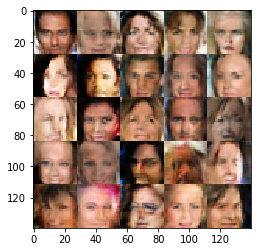

Estimated time remaining of epoch: 0:02:40.455092
Epoch 1/1...   83.9%  Discriminator Loss: 0.5365... Generator Loss: 2.2653
Epoch 1/1...   84.0%  Discriminator Loss: 0.9027... Generator Loss: 1.3604
Epoch 1/1...   84.2%  Discriminator Loss: 0.6752... Generator Loss: 1.7222
Epoch 1/1...   84.3%  Discriminator Loss: 0.5876... Generator Loss: 3.2009
Epoch 1/1...   84.5%  Discriminator Loss: 0.5946... Generator Loss: 1.7003
Epoch 1/1...   84.6%  Discriminator Loss: 0.5519... Generator Loss: 2.5039
Epoch 1/1...   84.8%  Discriminator Loss: 0.6660... Generator Loss: 2.0698
Epoch 1/1...   85.0%  Discriminator Loss: 0.7424... Generator Loss: 1.5024
Epoch 1/1...   85.1%  Discriminator Loss: 0.6472... Generator Loss: 1.7449
Epoch 1/1...   85.3%  Discriminator Loss: 1.1970... Generator Loss: 1.1251


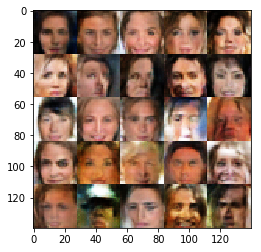

Estimated time remaining of epoch: 0:02:26.916941
Epoch 1/1...   85.4%  Discriminator Loss: 0.7460... Generator Loss: 1.5112
Epoch 1/1...   85.6%  Discriminator Loss: 0.5564... Generator Loss: 1.7078
Epoch 1/1...   85.8%  Discriminator Loss: 0.4457... Generator Loss: 2.4197
Epoch 1/1...   85.9%  Discriminator Loss: 0.4210... Generator Loss: 2.6277
Epoch 1/1...   86.1%  Discriminator Loss: 0.5304... Generator Loss: 2.7166
Epoch 1/1...   86.2%  Discriminator Loss: 0.6687... Generator Loss: 1.6904
Epoch 1/1...   86.4%  Discriminator Loss: 0.7459... Generator Loss: 1.8639
Epoch 1/1...   86.5%  Discriminator Loss: 0.5299... Generator Loss: 2.2318
Epoch 1/1...   86.7%  Discriminator Loss: 0.7672... Generator Loss: 2.2411
Epoch 1/1...   86.9%  Discriminator Loss: 0.5558... Generator Loss: 2.1606


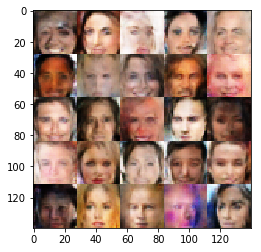

Estimated time remaining of epoch: 0:02:09.632066
Epoch 1/1...   87.0%  Discriminator Loss: 0.6131... Generator Loss: 2.6591
Epoch 1/1...   87.2%  Discriminator Loss: 0.6021... Generator Loss: 1.8428
Epoch 1/1...   87.3%  Discriminator Loss: 0.7657... Generator Loss: 1.3068
Epoch 1/1...   87.5%  Discriminator Loss: 0.8610... Generator Loss: 1.3512
Epoch 1/1...   87.6%  Discriminator Loss: 0.4900... Generator Loss: 2.1294
Epoch 1/1...   87.8%  Discriminator Loss: 0.5764... Generator Loss: 2.2079
Epoch 1/1...   88.0%  Discriminator Loss: 0.7088... Generator Loss: 1.1349
Epoch 1/1...   88.1%  Discriminator Loss: 0.6629... Generator Loss: 3.3442
Epoch 1/1...   88.3%  Discriminator Loss: 0.6481... Generator Loss: 2.5904
Epoch 1/1...   88.4%  Discriminator Loss: 0.6330... Generator Loss: 1.7727


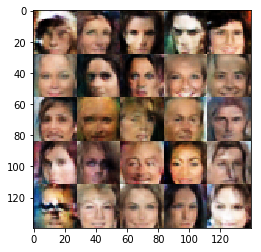

Estimated time remaining of epoch: 0:01:54.324608
Epoch 1/1...   88.6%  Discriminator Loss: 0.6265... Generator Loss: 1.9035
Epoch 1/1...   88.8%  Discriminator Loss: 0.5815... Generator Loss: 1.8265
Epoch 1/1...   88.9%  Discriminator Loss: 0.5640... Generator Loss: 2.4665
Epoch 1/1...   89.1%  Discriminator Loss: 0.6870... Generator Loss: 2.0388
Epoch 1/1...   89.2%  Discriminator Loss: 0.5575... Generator Loss: 2.4517
Epoch 1/1...   89.4%  Discriminator Loss: 0.6802... Generator Loss: 1.7266
Epoch 1/1...   89.5%  Discriminator Loss: 0.5517... Generator Loss: 1.8354
Epoch 1/1...   89.7%  Discriminator Loss: 0.4778... Generator Loss: 2.2735
Epoch 1/1...   89.9%  Discriminator Loss: 0.6085... Generator Loss: 1.6136
Epoch 1/1...   90.0%  Discriminator Loss: 0.6789... Generator Loss: 1.8863


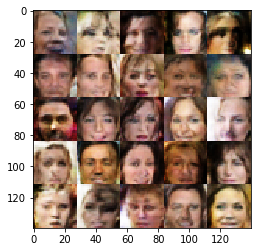

Estimated time remaining of epoch: 0:01:38.563232
Epoch 1/1...   90.2%  Discriminator Loss: 0.7044... Generator Loss: 1.7524
Epoch 1/1...   90.3%  Discriminator Loss: 0.5426... Generator Loss: 2.1725
Epoch 1/1...   90.5%  Discriminator Loss: 0.7970... Generator Loss: 2.9893
Epoch 1/1...   90.6%  Discriminator Loss: 0.5994... Generator Loss: 2.0390
Epoch 1/1...   90.8%  Discriminator Loss: 0.7747... Generator Loss: 1.3824
Epoch 1/1...   91.0%  Discriminator Loss: 0.5215... Generator Loss: 2.3432
Epoch 1/1...   91.1%  Discriminator Loss: 0.6192... Generator Loss: 2.3647
Epoch 1/1...   91.3%  Discriminator Loss: 0.5125... Generator Loss: 3.0731
Epoch 1/1...   91.4%  Discriminator Loss: 0.8305... Generator Loss: 1.4086
Epoch 1/1...   91.6%  Discriminator Loss: 0.7221... Generator Loss: 2.2219


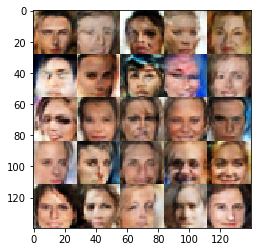

Estimated time remaining of epoch: 0:01:22.973542
Epoch 1/1...   91.8%  Discriminator Loss: 0.5363... Generator Loss: 2.4922
Epoch 1/1...   91.9%  Discriminator Loss: 0.5954... Generator Loss: 2.4420
Epoch 1/1...   92.1%  Discriminator Loss: 0.5102... Generator Loss: 2.6291
Epoch 1/1...   92.2%  Discriminator Loss: 0.4947... Generator Loss: 2.2853
Epoch 1/1...   92.4%  Discriminator Loss: 0.8455... Generator Loss: 1.6895
Epoch 1/1...   92.5%  Discriminator Loss: 0.7530... Generator Loss: 1.0594
Epoch 1/1...   92.7%  Discriminator Loss: 0.8525... Generator Loss: 1.0833
Epoch 1/1...   92.9%  Discriminator Loss: 0.6269... Generator Loss: 2.1250
Epoch 1/1...   93.0%  Discriminator Loss: 0.6887... Generator Loss: 1.5537
Epoch 1/1...   93.2%  Discriminator Loss: 0.7847... Generator Loss: 1.8036


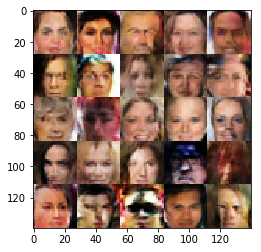

Estimated time remaining of epoch: 0:01:07.340335
Epoch 1/1...   93.3%  Discriminator Loss: 0.5131... Generator Loss: 1.9688
Epoch 1/1...   93.5%  Discriminator Loss: 0.5079... Generator Loss: 2.5403
Epoch 1/1...   93.7%  Discriminator Loss: 0.5808... Generator Loss: 2.2984
Epoch 1/1...   93.8%  Discriminator Loss: 0.5241... Generator Loss: 2.9010
Epoch 1/1...   94.0%  Discriminator Loss: 0.6871... Generator Loss: 2.8584
Epoch 1/1...   94.1%  Discriminator Loss: 1.5739... Generator Loss: 0.5000
Epoch 1/1...   94.3%  Discriminator Loss: 0.5437... Generator Loss: 2.5147
Epoch 1/1...   94.4%  Discriminator Loss: 0.5414... Generator Loss: 1.8896
Epoch 1/1...   94.6%  Discriminator Loss: 0.4813... Generator Loss: 2.5807
Epoch 1/1...   94.8%  Discriminator Loss: 0.5852... Generator Loss: 2.6553


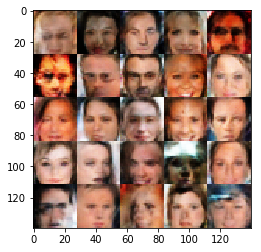

Estimated time remaining of epoch: 0:00:51.792608
Epoch 1/1...   94.9%  Discriminator Loss: 0.6668... Generator Loss: 2.1386
Epoch 1/1...   95.1%  Discriminator Loss: 0.4947... Generator Loss: 2.2792
Epoch 1/1...   95.2%  Discriminator Loss: 0.5872... Generator Loss: 1.8295
Epoch 1/1...   95.4%  Discriminator Loss: 0.4840... Generator Loss: 3.8662
Epoch 1/1...   95.5%  Discriminator Loss: 0.5214... Generator Loss: 2.9644
Epoch 1/1...   95.7%  Discriminator Loss: 0.4813... Generator Loss: 2.2446
Epoch 1/1...   95.9%  Discriminator Loss: 0.5932... Generator Loss: 2.1661
Epoch 1/1...   96.0%  Discriminator Loss: 0.5857... Generator Loss: 2.4231
Epoch 1/1...   96.2%  Discriminator Loss: 0.9202... Generator Loss: 1.5480
Epoch 1/1...   96.3%  Discriminator Loss: 0.5593... Generator Loss: 2.3122


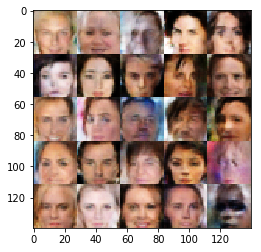

Estimated time remaining of epoch: 0:00:36.266225
Epoch 1/1...   96.5%  Discriminator Loss: 0.4958... Generator Loss: 3.1126
Epoch 1/1...   96.7%  Discriminator Loss: 0.7112... Generator Loss: 1.8294
Epoch 1/1...   96.8%  Discriminator Loss: 1.1501... Generator Loss: 0.8366
Epoch 1/1...   97.0%  Discriminator Loss: 0.6307... Generator Loss: 2.9071
Epoch 1/1...   97.1%  Discriminator Loss: 0.4278... Generator Loss: 3.0836
Epoch 1/1...   97.3%  Discriminator Loss: 0.7050... Generator Loss: 2.4928
Epoch 1/1...   97.4%  Discriminator Loss: 0.6878... Generator Loss: 1.9274
Epoch 1/1...   97.6%  Discriminator Loss: 0.6355... Generator Loss: 2.3026
Epoch 1/1...   97.8%  Discriminator Loss: 0.6410... Generator Loss: 1.9517
Epoch 1/1...   97.9%  Discriminator Loss: 0.6476... Generator Loss: 1.4207


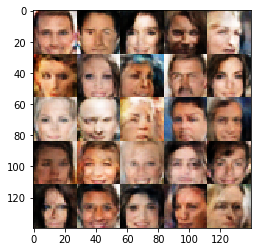

Estimated time remaining of epoch: 0:00:20.716704
Epoch 1/1...   98.1%  Discriminator Loss: 0.5929... Generator Loss: 1.8202
Epoch 1/1...   98.2%  Discriminator Loss: 0.6225... Generator Loss: 3.5935
Epoch 1/1...   98.4%  Discriminator Loss: 0.5999... Generator Loss: 1.6558
Epoch 1/1...   98.5%  Discriminator Loss: 0.4805... Generator Loss: 4.4987
Epoch 1/1...   98.7%  Discriminator Loss: 0.6633... Generator Loss: 1.8720
Epoch 1/1...   98.9%  Discriminator Loss: 0.5983... Generator Loss: 2.2100
Epoch 1/1...   99.0%  Discriminator Loss: 0.7052... Generator Loss: 1.5257
Epoch 1/1...   99.2%  Discriminator Loss: 0.7980... Generator Loss: 2.8640
Epoch 1/1...   99.3%  Discriminator Loss: 0.6541... Generator Loss: 1.1157
Epoch 1/1...   99.5%  Discriminator Loss: 0.7497... Generator Loss: 2.1050


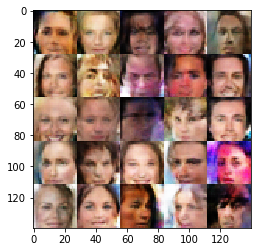

Estimated time remaining of epoch: 0:00:05.147245
Epoch 1/1...   99.7%  Discriminator Loss: 0.6796... Generator Loss: 1.7520
Epoch 1/1...   99.8%  Discriminator Loss: 0.6254... Generator Loss: 2.2032
Epoch 1/1...  100.0%  Discriminator Loss: 0.5867... Generator Loss: 2.1523


In [111]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.